# Lockdown  for Regression: Communities and Crime Unnormalized Data Set
Author: Wilmer Arbelo Gonzalez

## Import all necessary libraries

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import sys
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

## Datasets and DataLoaders

In [2]:
# Load data
def load_data(fname, i=1):
    """
    input (str or path): name of the folder with the data.
    This function reads the data, transforms it to tensors, and makes it
    global.
    """
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
# 
    df = pd.read_csv(os.path.join(fname, 'xtrain'+str(i)+'.csv'), index_col=False)
    xtrain = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xvalid'+str(i)+'.csv'), index_col=False)
    xvalid = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtest'+str(i)+'.csv'), index_col=False)
    xtest = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtrain_valid'+str(i)+'.csv'), index_col=False)
    xtrain_valid = torch.tensor(df.values).float()
# 
    df = pd.read_csv(os.path.join(fname, 'ytrain'+str(i)+'.csv'), index_col=False)
    ytrain = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'yvalid'+str(i)+'.csv'), index_col=False)
    yvalid = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'ytest'+str(i)+'.csv'), index_col=False)
    ytest = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'ytrain_valid'+str(i)+'.csv'), index_col=False)
    ytrain_valid = torch.tensor(df.values).float()


In [3]:
# Transform DataFrame to Tensor
def df_to_tensor():
    """
    This function transforms DataFrames to tensors and makes them global.
    """
    global xtrain, xvalid, xtest, ytrain, yvalid, ytest
# 
    xtrain = torch.tensor(xtrain.values).float()
    xvalid = torch.tensor(xvalid.values).float()
    xtest = torch.tensor(xtest.values).float()
# 
    ytrain = torch.tensor(ytrain.values).float()
    yvalid = torch.tensor(yvalid.values).float()
    ytest = torch.tensor(ytest.values).float()

* ### Read and Clean Data

In [4]:
# Feature names:
col_names = [
    'communityname',
    'State',
    'countyCode',
    'communityCode',
    'fold',
    'pop',
    'perHoush',
    'pctBlack',
    'pctWhite',
    'pctAsian',
    'pctHisp',
    'pct12_21',
    'pct12_29',
    'pct16_24',
    'pct65up',
    'persUrban',
    'pctUrban',
    'medIncome',
    'pctWwage',
    'pctWfarm',
    'pctWdiv',
    'pctWsocsec',
    'pctPubAsst',
    'pctRetire',
    'medFamIncome',
    'perCapInc',
    'whitePerCap',
    'blackPerCap',
    'NAperCap',
    'asianPerCap',
    'otherPerCap',
    'hispPerCap',
    'persPoverty',
    'pctPoverty',
    'pctLowEdu',
    'pctNotHSgrad',
    'pctCollGrad',
    'pctUnemploy',
    'pctEmploy',
    'pctEmployMfg',
    'pctEmployProfServ',
    'pctOccupManu',
    'pctOccupMgmt',
    'pctMaleDivorc',
    'pctMaleNevMar',
    'pctFemDivorc',
    'pctAllDivorc',
    'persPerFam',
    'pct2Par',
    'pctKids2Par',
    'pctKids_4w2Par',
    'pct12_17w2Par',
    'pctWorkMom_6',
    'pctWorkMom_18',
    'kidsBornNevrMarr',
    'pctKidsBornNevrMarr',
    'numForeignBorn',
    'pctFgnImmig_3',
    'pctFgnImmig_5',
    'pctFgnImmig_8',
    'pctFgnImmig_10',
    'pctImmig_3',
    'pctImmig_5',
    'pctImmig_8',
    'pctImmig_10',
    'pctSpeakOnlyEng',
    'pctNotSpeakEng',
    'pctLargHousFam',
    'pctLargHous',
    'persPerOccupHous',
    'persPerOwnOccup',
    'persPerRenterOccup',
    'pctPersOwnOccup',
    'pctPopDenseHous',
    'pctSmallHousUnits',
    'medNumBedrm',
    'houseVacant',
    'pctHousOccup',
    'pctHousOwnerOccup',
    'pctVacantBoarded',
    'pctVacant6up',
    'medYrHousBuilt',
    'pctHousWOphone',
    'pctHousWOplumb',
    'ownHousLowQ',
    'ownHousMed',
    'ownHousUperQ',
    'ownHousQrange',
    'rentLowQ',
    'rentMed',
    'rentUpperQ',
    'rentQrange',
    'medGrossRent',
    'medRentpctHousInc',
    'medOwnCostpct',
    'medOwnCostPctWO',
    'persEmergShelt',
    'persHomeless',
    'pctForeignBorn',
    'pctBornStateResid',
    'pctSameHouse_5',
    'pctSameCounty_5',
    'pctSameState_5',
    'numPolice',
    'policePerPop',
    'policeField',
    'policeFieldPerPop',
    'policeCalls',
    'policCallPerPop',
    'policCallPerOffic',
    'policePerPop2',
    'racialMatch',
    'pctPolicWhite',
    'pctPolicBlack',
    'pctPolicHisp',
    'pctPolicAsian',
    'pctPolicMinority',
    'officDrugUnits',
    'numDiffDrugsSeiz',
    'policAveOT',
    'landArea',
    'popDensity',
    'pctUsePubTrans',
    'policCarsAvail',
    'policOperBudget',
    'pctPolicPatrol',
    'gangUnit',
    'pctOfficDrugUnit',
    'policBudgetPerPop',
    'murders',
    'murdPerPop',
    'rapes',
    'rapesPerPop',
    'robberies',
    'robbbPerPop',
    'assaults',
    'assaultPerPop',
    'burglaries',
    'burglPerPop',
    'larcenies',
    'larcPerPop',
    'autoTheft',
    'autoTheftPerPop',
    'arsons',
    'arsonsPerPop',
    'violentPerPop',
    'nonViolPerPop'
]

col_2drop = [
    'communityname',
    'State',
    'countyCode',
    'communityCode',
    'fold',
    'murders',
    'murdPerPop',
    'rapes',
    'rapesPerPop',
    'robberies',
    'robbbPerPop',
    'assaults',
    'assaultPerPop',
    'burglaries',
    'burglPerPop',
    'larcenies',
    'larcPerPop',
    'autoTheft',
    'autoTheftPerPop',
    'arsons',
    'arsonsPerPop'
]

In [5]:
# Read Dataset(s)
df = pd.read_csv('dataset_04CrimeUnnormalized/CommViolPredUnnormalizedData.txt', 
                 header=None, 
                 names=col_names, 
                 index_col=False)

# Clean Dataset(s)
df.drop(columns=col_2drop, inplace=True)
df = df.replace('?', np.nan)
df = df.astype(float)

df1 = df.drop(columns='violentPerPop')
df2 = df.drop(columns='nonViolPerPop')

df1.dropna(subset=['nonViolPerPop'], inplace=True)
df2.dropna(subset=['violentPerPop'], inplace=True)

df1.fillna(df1.mean(), inplace=True)
df2.fillna(df2.mean(), inplace=True)

print("- Dataset 1 size: {} points.".format(len(df1)))
print("  Missing values: {} points".format(df1.isna().sum().sum()))
print("  Target: '{}'\n".format(df1.columns[-1]))

print("- Dataset 2 size: {} points.".format(len(df2)))
print("  Missing values: {} points".format(df2.isna().sum().sum()))
print("  Target: '{}'\n".format(df2.columns[-1]))

print("- Number of features: {}\n".format(df1.shape[1]-1))
print("- Feature names:\n{}".format(df1.columns[0:-1].tolist()))


- Dataset 1 size: 2118 points.
  Missing values: 0 points
  Target: 'nonViolPerPop'

- Dataset 2 size: 1994 points.
  Missing values: 0 points
  Target: 'violentPerPop'

- Number of features: 124

- Feature names:
['pop', 'perHoush', 'pctBlack', 'pctWhite', 'pctAsian', 'pctHisp', 'pct12_21', 'pct12_29', 'pct16_24', 'pct65up', 'persUrban', 'pctUrban', 'medIncome', 'pctWwage', 'pctWfarm', 'pctWdiv', 'pctWsocsec', 'pctPubAsst', 'pctRetire', 'medFamIncome', 'perCapInc', 'whitePerCap', 'blackPerCap', 'NAperCap', 'asianPerCap', 'otherPerCap', 'hispPerCap', 'persPoverty', 'pctPoverty', 'pctLowEdu', 'pctNotHSgrad', 'pctCollGrad', 'pctUnemploy', 'pctEmploy', 'pctEmployMfg', 'pctEmployProfServ', 'pctOccupManu', 'pctOccupMgmt', 'pctMaleDivorc', 'pctMaleNevMar', 'pctFemDivorc', 'pctAllDivorc', 'persPerFam', 'pct2Par', 'pctKids2Par', 'pctKids_4w2Par', 'pct12_17w2Par', 'pctWorkMom_6', 'pctWorkMom_18', 'kidsBornNevrMarr', 'pctKidsBornNevrMarr', 'numForeignBorn', 'pctFgnImmig_3', 'pctFgnImmig_5', 'pct

* ### Split and Save

In [6]:
# # Random seeds for the splits
# seed1 = torch.randint(0, 1000, (500,))
# seed2 = torch.randint(1001, 2000, (500,))
seed1 = pd.read_csv('seed1.csv', header=None).iloc[:,0].tolist()
seed2 = pd.read_csv('seed2.csv', header=None).iloc[:,0].tolist()

In [7]:
# Split data (function)
def split_data(dfX, dfy, seed1=0, seed2=42):
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
    xtrain_valid, xtest, ytrain_valid, ytest = train_test_split(dfX, dfy, 
                                                      test_size=0.2, 
                                                      random_state=seed1)
    xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_valid, ytrain_valid, 
                                                      test_size=0.25, 
                                                      random_state=seed2)

In [8]:
# Set (xtrain, ytrain), (xvalid, yvalid), and (xtest, ytest) for 'df1'
data_folder = 'dataset_04CrimeUnnormalized'

target = ['nonViolPerPop']
X = df1.drop(columns=target)
y = df1[target]
split_data(X, y)

# Save data on disk
cols_all1 = xtrain.columns.tolist()
xtrain.to_csv(os.path.join(data_folder, 'xtrain1.csv'), index=False)
xvalid.to_csv(os.path.join(data_folder, 'xvalid1.csv'), index=False)
xtest.to_csv(os.path.join(data_folder, 'xtest1.csv'), index=False)
xtrain_valid.to_csv(os.path.join(data_folder, 'xtrain_valid1.csv'), index=False)
X.to_csv(os.path.join(data_folder, 'X1.csv'), index=False)

ytrain.to_csv(os.path.join(data_folder, 'ytrain1.csv'), index=False)
yvalid.to_csv(os.path.join(data_folder, 'yvalid1.csv'), index=False)
ytest.to_csv(os.path.join(data_folder, 'ytest1.csv'), index=False)
ytrain_valid.to_csv(os.path.join(data_folder, 'ytrain_valid1.csv'), index=False)
y.to_csv(os.path.join(data_folder, 'y1.csv'), index=False)

# 
print("- xtrain1 size: {}".format(xtrain.shape))
print("- xvalid1 size: {}".format(xvalid.shape))
print("- xtest1 size: {}".format(xtest.shape))
print("- xtrain_valid1 size: {}\n".format(xtrain_valid.shape))

- xtrain1 size: (1270, 124)
- xvalid1 size: (424, 124)
- xtest1 size: (424, 124)
- xtrain_valid1 size: (1694, 124)



In [9]:
# Set (xtrain, ytrain), (xvalid, yvalid), and (xtest, ytest) for 'df2'
data_folder = 'dataset_04CrimeUnnormalized'

target = ['violentPerPop']
X = df2.drop(columns=target)
y = df2[target]
split_data(X, y)

# Save data on disk
cols_all2 = xtrain.columns.tolist()
xtrain.to_csv(os.path.join(data_folder, 'xtrain2.csv'), index=False)
xvalid.to_csv(os.path.join(data_folder, 'xvalid2.csv'), index=False)
xtest.to_csv(os.path.join(data_folder, 'xtest2.csv'), index=False)
xtrain_valid.to_csv(os.path.join(data_folder, 'xtrain_valid2.csv'), index=False)
X.to_csv(os.path.join(data_folder, 'X2.csv'), index=False)

ytrain.to_csv(os.path.join(data_folder, 'ytrain2.csv'), index=False)
yvalid.to_csv(os.path.join(data_folder, 'yvalid2.csv'), index=False)
ytest.to_csv(os.path.join(data_folder, 'ytest2.csv'), index=False)
ytrain_valid.to_csv(os.path.join(data_folder, 'ytrain_valid2.csv'), index=False)
y.to_csv(os.path.join(data_folder, 'y2.csv'), index=False)

# 
print("- xtrain2 size: {}".format(xtrain.shape))
print("- xvalid2 size: {}".format(xvalid.shape))
print("- xtest2 size: {}".format(xtest.shape))
print("- xtrain_valid2 size: {}\n".format(xtrain_valid.shape))

- xtrain2 size: (1196, 124)
- xvalid2 size: (399, 124)
- xtest2 size: (399, 124)
- xtrain_valid2 size: (1595, 124)



* ### Create Datasets and DataLoaders

In [10]:
# Create Dataset class
class MyDataset(Dataset):
    '''
    Input:
        xtensor (torch tensor): data points; dimension [# of points, # of features]
        ytensor (torch tensor): y values; dimension [# of points]
    Output:
        the usual...
    '''
    def __init__(self, xtensor, ytensor):
        self.x = xtensor
        self.y = ytensor
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx], idx

In [11]:
# Instantiate DataLoaders
def make_DataLoaders(batch_size=100000, num_workers = 0):
    """
    This function instantiate and makes global DataLoaders for training, 
    validation, and testing datasets. 
    """
# .create datasets
    train_dataset = MyDataset(xtrain, ytrain)
    valid_dataset = MyDataset(xvalid, yvalid)
    test_dataset = MyDataset(xtest, ytest)
    
# .make dataloaders global variables
    global train_dataloader, valid_dataloader, test_dataloader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = False, 
                                                   num_workers=num_workers)
    print('- train minibatches =', len(train_dataloader))
    print('- valid minibatches =', len(valid_dataloader))
    print('- test minibatches =', len(test_dataloader))

In [12]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


## Optimizer and Loss Function

In [13]:
# Set up SGD optimizer with a constant learning rate
def setup_SGD(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.SGD(model.parameters(), lr=lr, momentum=0,  weight_decay=0.0)

In [14]:
# Set up Adam optimizer with a constant learning rate
def setup_ADAM(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.Adam(model.parameters(), lr=lr,  weight_decay=0.0)

In [15]:
# Type of Loss Function
loss_type = nn.MSELoss(reduction='mean')

## Train model

In [16]:
# PyTorch sign function
def sgn(x):
    return torch.sign(x)

In [17]:
# Train model (regression)
def train_model(lr, features, layer_sizes, lock_flag=False, epochs=3000, 
                early_stop=300, fname='model'):
    """
    """
# Set seed of random generators (for reproducibility purposes)
    torch.manual_seed(42)

# Instantiate Model and Optimizer
    model = MyNet(features, layer_sizes)
    if lock_flag == True:
        model.load_state_dict(torch.load(model_forward_name))
    model = model.to(device)
    optimizer = setup_SGD(model, lr)

# LOCKDOWN SECTION 1:
    if lock_flag == True:
        n_iterations = epochs*len(train_dataloader)
        layers = get_lockdown_layers(model)
        t0 = []
        t0_initial = []
        sign_w0 = []
        l = 0
        for layer in layers:
            ww = layer.weight.detach()
            t0.append(abs(ww).sum())
            sign_w0.append(torch.sign(ww))
            t0_initial.append(t0[l])
            l += 1
    
# DataFrames to store train/valid loss function
    train_loss = pd.DataFrame(columns=['iteration', 'loss'])
    valid_loss = pd.DataFrame(columns=['iteration', 'loss'])

# Initialize some local variables...
    iteration = 0
    best_iter = 0
    best_loss = np.inf
    stop_flag = 0

# Loop Over Number of Epochs
    iterator = tqdm.notebook.tqdm(range(1, epochs + 1), desc='Epochs loop')
    for n_epoch in iterator:
# 
# .Loop Over Mini-batches
        for ibatch, (xx, yy, _) in enumerate(train_dataloader, start=1):
#
# ..Compute Validation Loss
            model_dict = copy.deepcopy(model.state_dict())
            epoch_loss = valid_epoch(valid_dataloader, model, loss_type, device)
            valid_loss = valid_loss.append({'iteration': iteration + 1, 
                                            'loss': epoch_loss}, 
                                            ignore_index=True)
# ..Train Mini-batch:
            model.train()
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)

# ..Compute Train Loss
            loss = loss_type(yy_pred, yy) #.view(-1)
            train_loss = train_loss.append({'iteration': iteration + 1,
                                            'loss': loss.item()}, 
                                           ignore_index=True)
# ..Backward Propagation
            optimizer.zero_grad()
            loss.backward()

# ..LOCKDOWN SECTION 2:
            if lock_flag == True:
                l = 0
                for layer in layers:
# ...weights and gradients (2D)
                    w2d = layer.weight.detach()
                    g2d = layer.weight.grad.detach()
                    w_shape = g2d.size()

# ...flattens weights and compute P(W)
                    w1d = torch.flatten(w2d)
                    Pw = abs(w1d).sum()

# ...find g=-grads, 'gamma', and sort gamma (in descending order)
                    p1d = 1.0
                    g1d = -torch.flatten(g2d)
                    gamma = abs(g1d)/(p1d + 1e-10)
                    _, indx1d = torch.sort(gamma, descending=True)

# ...Modify Gradients Accordingly:
                    grmin = torch.zeros(w_shape).fill_(1e-1).to(device)
                    layer.weight.grad = torch.sign(g2d)*torch.max(abs(g2d), grmin)
                    gr1d = torch.flatten(layer.weight.grad.detach())
                    pjsj = lr*abs(gr1d[indx1d])

# ...sign(g) != sign(w) elements
                    mask_ds = (sgn(g1d[indx1d]) != sgn(w1d[indx1d])) & (w1d[indx1d] != 0.0)
                    DS_sum = pjsj[mask_ds].sum()
                    pjsj[mask_ds] = 0.0
                    mask_dsc = ~mask_ds
                    indx1d_dsc = indx1d[mask_dsc]

# ...sum(pjsj), j={1,J-1}
                    left_side = torch.cumsum(pjsj, dim=0) - pjsj
                    pjsj_dsc = torch.zeros(len(g1d)).to(device)
                    pjsj_dsc[:] = pjsj[:]

# ...sum(pjsj) + Penalty, j={J+1,nJ}
                    mask_w0 = (w1d[indx1d] == 0.0)
                    pjsj_dsc[mask_w0] = 0.0
                    right_side = pjsj_dsc.sum() - torch.cumsum(pjsj_dsc, dim=0) + DS_sum - Pw + t0[l]

# ...delta_j and new steps
                    ds = right_side - left_side
                    mask_w0 = (~mask_w0).float()
                    pjsj_new = -mask_w0**(1-sgn(ds))*sgn(g1d[indx1d])*sgn(ds)*torch.min(pjsj, abs(ds))

# ...modify gradients
                    indx2d = np.unravel_index(indx1d_dsc.cpu(), shape=w_shape)
                    layer.weight.grad[indx2d] = pjsj_new[mask_dsc]/lr
                    l = l + 1

# ..Update Weights 
            optimizer.step()

# ..LOCKDOWN SECTION 3:
            if lock_flag == True:
# ...Set Weights That Change Signs to Zero
                l = 0
                for layer in layers:
                    ww = layer.weight.detach()
                    sign_w = sgn(ww)
                    mask0 = ((sign_w != sign_w0[l]) & (sign_w0[l] != 0.0))
                    with torch.no_grad():
                        layer.weight[mask0] = 0.0
                    sign_w0[l] = sign_w
                    
# ...Tighten Constraint
                    if iteration%step == 0:
                        t0[l] = (1.0 - iteration/n_iterations)*t0_initial[l]
                    l = l + 1
                    

# ..Early Stop
            batch_loss = valid_loss.iloc[iteration, 1]
            if batch_loss < best_loss:
                torch.save(model_dict, fname+"_best.pth")
                best_loss = batch_loss
                best_iter = iteration
            else:
                if iteration - best_iter >= early_stop:
                    stop_flag = 1
                    break
# 
            iteration += 1
# 
        if stop_flag == 1:
            break
# 
    if lock_flag == False:
        torch.save(model_dict, fname+"_last.pth")
    print("Summary:")
    print("-learning rate = {:.5f}".format(lr))
    if stop_flag == 1:
        print('-path 1 has early stopped:')
        print(' {:d} iterations with no improvement in valid loss.'.format(early_stop))
    print("-Model saved after iteration {:d}.".format(best_iter + 1))
    print("-Train.  Loss={:.7f}".format(train_loss.iloc[best_iter, 1]))
    print("-Valid.  Loss={:.7f}".format(valid_loss.iloc[best_iter, 1]))
# 
    return train_loss, valid_loss

In [18]:
# Evaluate one epoch (regression)
def valid_epoch(data_loader, model, loss_type, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Values of Loss Function after one epoch.
    """
# Initialize some local variables
    loss_fun = 0.
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute loss function
            batch_size = len(yy)
            loss = loss_type(yy_pred, yy)
            loss_fun += batch_size*loss.item()
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return loss_fun/n_points

## Results:

* ### Lasso

* #### Target 1

In [423]:
# Load data
load_data('dataset_04CrimeUnnormalized', i=1)

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [424]:
# Normalize data
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

scaler = StandardScaler()
scaler.fit(ytrain)
ytrain = scaler.transform(ytrain)
yvalid = scaler.transform(yvalid)
ytest  = scaler.transform(ytest)

In [425]:
# Grid search space
grid_alpha = np.geomspace(1e-4, 1.0, num=1000)
df_grid_loss = pd.DataFrame(columns = ['alpha', 'valid_mse', 'valid_r2'], 
                            index=range(len(grid_alpha)))

params = {'max_iter': 100000,
          'random_state': 42,
          'warm_start': True}

In [426]:
# Perform grid search
data_out = 'data_lasso_04CrimeUnnormalized'
iterator = tqdm.notebook.tqdm(range(1, len(grid_alpha) + 1), desc='alpha-grid loop')
for n in iterator:
    irow = n-1
    params['alpha'] = grid_alpha[irow]
    log_reg = Lasso(**params).fit(xtrain, ytrain.ravel())
    
    ypred = log_reg.predict(xvalid)
    val_mse = mean_squared_error(yvalid, ypred, squared=True)
    val_r2  = r2_score(yvalid, ypred)
    
    df_grid_loss.iloc[irow,:] = [params['alpha'], val_mse, val_r2]
    print("alpha={:.5f} | valid_mse={:.5f},  valid_r2={:.5f}".format(params['alpha'], 
                                                                     val_mse, 
                                                                     val_r2))
# .save grid search results
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss01.csv'), index=None)

alpha=0.00010 | valid_mse=0.45471,  valid_r2=0.52447
alpha=0.00010 | valid_mse=0.45460,  valid_r2=0.52459
alpha=0.00010 | valid_mse=0.45449,  valid_r2=0.52469
alpha=0.00010 | valid_mse=0.45439,  valid_r2=0.52480
alpha=0.00010 | valid_mse=0.45429,  valid_r2=0.52491
alpha=0.00010 | valid_mse=0.45419,  valid_r2=0.52501
alpha=0.00011 | valid_mse=0.45408,  valid_r2=0.52512
alpha=0.00011 | valid_mse=0.45398,  valid_r2=0.52523
alpha=0.00011 | valid_mse=0.45387,  valid_r2=0.52534
alpha=0.00011 | valid_mse=0.45377,  valid_r2=0.52545
alpha=0.00011 | valid_mse=0.45366,  valid_r2=0.52556
alpha=0.00011 | valid_mse=0.45356,  valid_r2=0.52567
alpha=0.00011 | valid_mse=0.45345,  valid_r2=0.52578
alpha=0.00011 | valid_mse=0.45334,  valid_r2=0.52590
alpha=0.00011 | valid_mse=0.45323,  valid_r2=0.52601
alpha=0.00011 | valid_mse=0.45312,  valid_r2=0.52613
alpha=0.00012 | valid_mse=0.45301,  valid_r2=0.52624
alpha=0.00012 | valid_mse=0.45290,  valid_r2=0.52636
alpha=0.00012 | valid_mse=0.45280,  valid_r2=0

alpha=0.00042 | valid_mse=0.44385,  valid_r2=0.53582
alpha=0.00042 | valid_mse=0.44380,  valid_r2=0.53587
alpha=0.00043 | valid_mse=0.44375,  valid_r2=0.53593
alpha=0.00043 | valid_mse=0.44370,  valid_r2=0.53598
alpha=0.00043 | valid_mse=0.44365,  valid_r2=0.53603
alpha=0.00044 | valid_mse=0.44360,  valid_r2=0.53609
alpha=0.00044 | valid_mse=0.44355,  valid_r2=0.53614
alpha=0.00045 | valid_mse=0.44349,  valid_r2=0.53620
alpha=0.00045 | valid_mse=0.44345,  valid_r2=0.53625
alpha=0.00045 | valid_mse=0.44339,  valid_r2=0.53630
alpha=0.00046 | valid_mse=0.44334,  valid_r2=0.53635
alpha=0.00046 | valid_mse=0.44329,  valid_r2=0.53641
alpha=0.00047 | valid_mse=0.44323,  valid_r2=0.53647
alpha=0.00047 | valid_mse=0.44317,  valid_r2=0.53653
alpha=0.00047 | valid_mse=0.44311,  valid_r2=0.53659
alpha=0.00048 | valid_mse=0.44305,  valid_r2=0.53666
alpha=0.00048 | valid_mse=0.44299,  valid_r2=0.53672
alpha=0.00049 | valid_mse=0.44293,  valid_r2=0.53678
alpha=0.00049 | valid_mse=0.44287,  valid_r2=0

alpha=0.00178 | valid_mse=0.43028,  valid_r2=0.55002
alpha=0.00179 | valid_mse=0.43005,  valid_r2=0.55025
alpha=0.00181 | valid_mse=0.42983,  valid_r2=0.55049
alpha=0.00182 | valid_mse=0.42961,  valid_r2=0.55072
alpha=0.00184 | valid_mse=0.42939,  valid_r2=0.55095
alpha=0.00186 | valid_mse=0.42918,  valid_r2=0.55117
alpha=0.00188 | valid_mse=0.42899,  valid_r2=0.55136
alpha=0.00189 | valid_mse=0.42882,  valid_r2=0.55154
alpha=0.00191 | valid_mse=0.42864,  valid_r2=0.55173
alpha=0.00193 | valid_mse=0.42847,  valid_r2=0.55191
alpha=0.00195 | valid_mse=0.42830,  valid_r2=0.55209
alpha=0.00196 | valid_mse=0.42812,  valid_r2=0.55227
alpha=0.00198 | valid_mse=0.42794,  valid_r2=0.55246
alpha=0.00200 | valid_mse=0.42778,  valid_r2=0.55263
alpha=0.00202 | valid_mse=0.42761,  valid_r2=0.55280
alpha=0.00204 | valid_mse=0.42745,  valid_r2=0.55297
alpha=0.00206 | valid_mse=0.42729,  valid_r2=0.55314
alpha=0.00208 | valid_mse=0.42713,  valid_r2=0.55331
alpha=0.00210 | valid_mse=0.42701,  valid_r2=0

alpha=0.00741 | valid_mse=0.42395,  valid_r2=0.55664
alpha=0.00748 | valid_mse=0.42406,  valid_r2=0.55652
alpha=0.00755 | valid_mse=0.42418,  valid_r2=0.55640
alpha=0.00762 | valid_mse=0.42430,  valid_r2=0.55627
alpha=0.00769 | valid_mse=0.42442,  valid_r2=0.55614
alpha=0.00776 | valid_mse=0.42455,  valid_r2=0.55601
alpha=0.00783 | valid_mse=0.42468,  valid_r2=0.55587
alpha=0.00790 | valid_mse=0.42482,  valid_r2=0.55573
alpha=0.00798 | valid_mse=0.42496,  valid_r2=0.55558
alpha=0.00805 | valid_mse=0.42511,  valid_r2=0.55542
alpha=0.00813 | valid_mse=0.42526,  valid_r2=0.55526
alpha=0.00820 | valid_mse=0.42533,  valid_r2=0.55519
alpha=0.00828 | valid_mse=0.42536,  valid_r2=0.55516
alpha=0.00835 | valid_mse=0.42539,  valid_r2=0.55513
alpha=0.00843 | valid_mse=0.42544,  valid_r2=0.55508
alpha=0.00851 | valid_mse=0.42548,  valid_r2=0.55503
alpha=0.00859 | valid_mse=0.42554,  valid_r2=0.55497
alpha=0.00867 | valid_mse=0.42560,  valid_r2=0.55491
alpha=0.00875 | valid_mse=0.42567,  valid_r2=0

alpha=0.03331 | valid_mse=0.44117,  valid_r2=0.53863
alpha=0.03361 | valid_mse=0.44156,  valid_r2=0.53822
alpha=0.03393 | valid_mse=0.44195,  valid_r2=0.53781
alpha=0.03424 | valid_mse=0.44236,  valid_r2=0.53738
alpha=0.03456 | valid_mse=0.44277,  valid_r2=0.53695
alpha=0.03488 | valid_mse=0.44317,  valid_r2=0.53653
alpha=0.03520 | valid_mse=0.44358,  valid_r2=0.53610
alpha=0.03553 | valid_mse=0.44400,  valid_r2=0.53567
alpha=0.03586 | valid_mse=0.44443,  valid_r2=0.53522
alpha=0.03619 | valid_mse=0.44487,  valid_r2=0.53476
alpha=0.03652 | valid_mse=0.44532,  valid_r2=0.53429
alpha=0.03686 | valid_mse=0.44571,  valid_r2=0.53388
alpha=0.03720 | valid_mse=0.44609,  valid_r2=0.53348
alpha=0.03755 | valid_mse=0.44648,  valid_r2=0.53307
alpha=0.03789 | valid_mse=0.44685,  valid_r2=0.53269
alpha=0.03825 | valid_mse=0.44718,  valid_r2=0.53234
alpha=0.03860 | valid_mse=0.44747,  valid_r2=0.53204
alpha=0.03896 | valid_mse=0.44776,  valid_r2=0.53174
alpha=0.03932 | valid_mse=0.44804,  valid_r2=0

alpha=0.15531 | valid_mse=0.51835,  valid_r2=0.45791
alpha=0.15675 | valid_mse=0.51907,  valid_r2=0.45716
alpha=0.15820 | valid_mse=0.51980,  valid_r2=0.45640
alpha=0.15966 | valid_mse=0.52054,  valid_r2=0.45563
alpha=0.16114 | valid_mse=0.52129,  valid_r2=0.45484
alpha=0.16263 | valid_mse=0.52205,  valid_r2=0.45404
alpha=0.16414 | valid_mse=0.52283,  valid_r2=0.45323
alpha=0.16566 | valid_mse=0.52362,  valid_r2=0.45240
alpha=0.16719 | valid_mse=0.52442,  valid_r2=0.45156
alpha=0.16874 | valid_mse=0.52524,  valid_r2=0.45071
alpha=0.17031 | valid_mse=0.52606,  valid_r2=0.44985
alpha=0.17188 | valid_mse=0.52690,  valid_r2=0.44897
alpha=0.17348 | valid_mse=0.52776,  valid_r2=0.44807
alpha=0.17508 | valid_mse=0.52862,  valid_r2=0.44717
alpha=0.17670 | valid_mse=0.52951,  valid_r2=0.44625
alpha=0.17834 | valid_mse=0.53040,  valid_r2=0.44531
alpha=0.17999 | valid_mse=0.53131,  valid_r2=0.44436
alpha=0.18166 | valid_mse=0.53223,  valid_r2=0.44339
alpha=0.18334 | valid_mse=0.53317,  valid_r2=0

alpha=0.77248 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.77964 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.78686 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.79415 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.80150 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.80892 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.81642 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.82398 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.83161 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.83931 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.84709 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.85493 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.86285 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.87084 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.87891 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.88705 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.89527 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.90356 | valid_mse=0.95740,  valid_r2=-0.00124
alpha=0.91193 | valid_mse=0.

In [427]:
# Display grid search results
data_out = 'data_lasso_04CrimeUnnormalized'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss01.csv'))

idx = df_grid_loss.valid_mse.idxmin()
best_alpha = df_grid_loss.iloc[idx, 0]
best_mse   = df_grid_loss.iloc[idx, 1]
print("Best parameters:")
print("- Best alpha = {:.3f}".format(best_alpha))
print("- Best valid loss = {}".format(best_mse))

Best parameters:
- Best alpha = 0.004
- Best valid loss = 0.42147740000000006


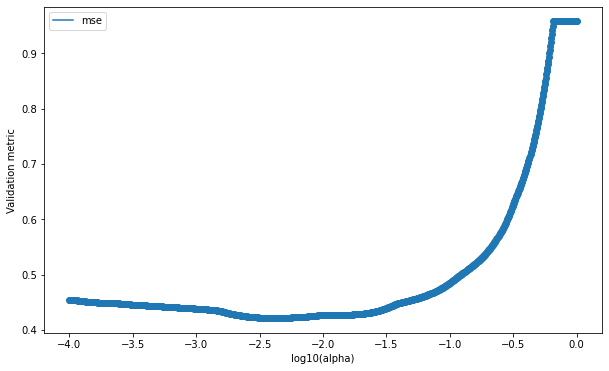

In [428]:
# Plot Loss vs point in grid search
data_out = 'data_lasso_04CrimeUnnormalized'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss01.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.alpha), df_grid_loss['valid_mse'])
axes.plot(np.log10(df_grid_loss.alpha), df_grid_loss['valid_mse'], label='mse')
# axes.scatter(df_grid_loss.index, df_grid_loss['valid_r2'])
# axes.plot(df_grid_loss.index, df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(alpha)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [429]:
# Train with best hyperparameters
params['alpha'] = best_alpha
log_reg = Lasso(**params).fit(xtrain, ytrain.ravel())

In [430]:
# Save model and model's best params
data_out = 'data_lasso_04CrimeUnnormalized'
joblib.dump(log_reg, os.path.join(data_out, 'lasso_model01_val.pkl'))
print("model saved at: '{}'".format(os.path.join(data_out, 'lasso_model01_val.pkl')))

best_params = {}
best_params['alpha'] = best_alpha
with open(os.path.join(data_out, 'lasso_best_params01.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'lasso_best_params01.json')))

model saved at: 'data_lasso_04CrimeUnnormalized/lasso_model01_val.pkl'
best params saved at: 'data_lasso_04CrimeUnnormalized/lasso_best_params01.json'


In [431]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_lasso_04CrimeUnnormalized'
model = joblib.load(os.path.join(data_out, 'lasso_model01_val.pkl'))

df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['mse', 'r2'])

ypred = model.predict(xtrain)
df_results.loc['train', 'mse'] = mean_squared_error(ytrain, ypred, squared=True)
df_results.loc['train', 'r2']   = r2_score(ytrain, ypred)

ypred = model.predict(xvalid)
df_results.loc['valid', 'mse'] = mean_squared_error(yvalid, ypred, squared=True)
df_results.loc['valid', 'r2']   = r2_score(yvalid, ypred)

ypred = model.predict(xtest)
df_results.loc['test', 'mse'] = mean_squared_error(ytest, ypred, squared=True)
df_results.loc['test', 'r2']   = r2_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_lasso01.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_lasso01.csv')))
df_results.head()

model results saved at: 'data_lasso_04CrimeUnnormalized/results_target_lasso01.csv'


,mse,r2
train,0.440463,0.559537
valid,0.421477,0.559221
test,0.332104,0.599624


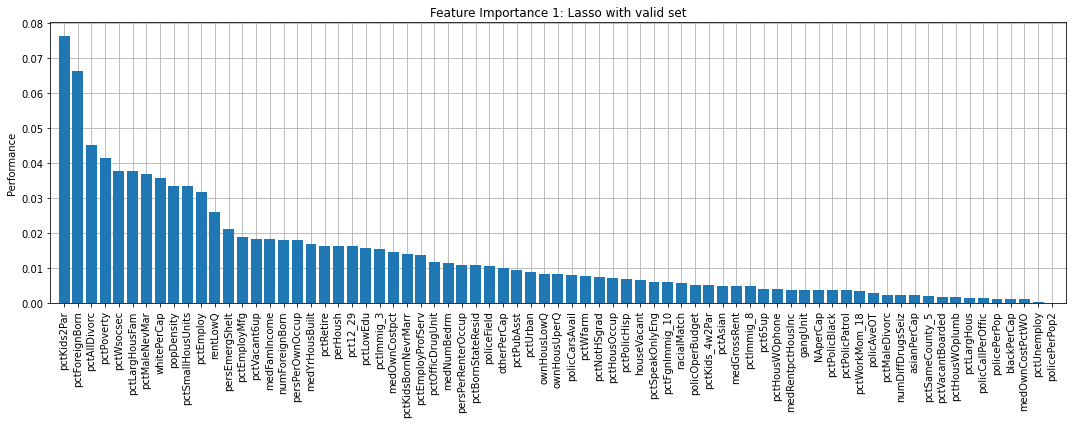

Feature importance graph saved at: 'data_lasso_04CrimeUnnormalized/feature_importance01_val.pdf'


In [432]:
# Feature importances
data_out = 'data_lasso_04CrimeUnnormalized'
mm = joblib.load(os.path.join(data_out, 'lasso_model01_val.pkl'))
ctmp = abs(mm.coef_)
ctmp = ctmp/ctmp.sum()

feature_importance = pd.Series(ctmp, index=cols_all1)
feature_importance_sorted = feature_importance.sort_values(ascending=False)

# Plot feature importances
idx = feature_importance_sorted > 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx.sum())
axes.bar(x_pos, feature_importance_sorted[idx], zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(feature_importance_sorted.index[idx], rotation='vertical')
axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Performance')
axes.set_title('Feature Importance 1: Lasso with valid set')
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance01_val.pdf'), bbox_inches='tight')
plt.show()
print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance01_val.pdf')))

In [433]:
# Find Accuracy +/- STD
data_out = 'data_lasso_04CrimeUnnormalized'
df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
                                   'train_r2', 'valid_r2', 'test_r2'])

model = joblib.load(os.path.join(data_out, 'lasso_model01_val.pkl'))

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_04CrimeUnnormalized/X1.csv')
    y = pd.read_csv('dataset_04CrimeUnnormalized/y1.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .normalize data sets
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xvalid = scaler.transform(xvalid)
    xtest  = scaler.transform(xtest)
    
    scaler = StandardScaler()
    scaler.fit(ytrain)
    ytrain = scaler.transform(ytrain)
    yvalid = scaler.transform(yvalid)
    ytest  = scaler.transform(ytest)
    
# .train model
    model.fit(xtrain, ytrain.ravel())
    
# .compute/save accuracy
    ypred = model.predict(xtrain)
    df_results.loc[n, 'train_mse'] = mean_squared_error(ytrain, ypred, squared=True)
    df_results.loc[n, 'train_r2']   = r2_score(ytrain, ypred)

    ypred = model.predict(xvalid)
    df_results.loc[n, 'valid_mse'] = mean_squared_error(yvalid, ypred, squared=True)
    df_results.loc[n, 'valid_r2']   = r2_score(yvalid, ypred)

    ypred = model.predict(xtest)
    df_results.loc[n, 'test_mse'] = mean_squared_error(ytest, ypred, squared=True)
    df_results.loc[n, 'test_r2']   = r2_score(ytest, ypred)

    joblib.dump(model, os.path.join(data_out, 'lasso_model01_val_'+str(n)+'.pkl'))
    df_results.to_csv(os.path.join(data_out, 'accuracy_lasso01_val.csv'), index=True)

In [434]:
# Display results
data_out = 'data_lasso_04CrimeUnnormalized'
accuracy = pd.read_csv(os.path.join(data_out, 'accuracy_lasso01_val.csv'))
print("Train mse = {:.3f} +/- {:.3f}".format(accuracy['train_mse'].mean(), 
                                              accuracy['train_mse'].std()))
print("Valid mse = {:.3f} +/- {:.3f}".format(accuracy['valid_mse'].mean(), 
                                              accuracy['valid_mse'].std()))
print("Test mse = {:.3f} +/- {:.3f}".format(accuracy['test_mse'].mean(), 
                                             accuracy['test_mse'].std()))

print("")
print("Train r2 = {:.3f} +/- {:.3f}".format(accuracy['train_r2'].mean(), 
                                            accuracy['train_r2'].std()))
print("Valid r2 = {:.3f} +/- {:.3f}".format(accuracy['valid_r2'].mean(), 
                                            accuracy['valid_r2'].std()))
print("Test r2 = {:.3f} +/- {:.3f}".format(accuracy['test_r2'].mean(), 
                                           accuracy['test_r2'].std()))

Train mse = 0.410 +/- 0.029
Valid mse = 0.485 +/- 0.123
Test mse = 0.470 +/- 0.114

Train r2 = 0.590 +/- 0.029
Valid r2 = 0.519 +/- 0.064
Test r2 = 0.532 +/- 0.068


* ### Gradient Boosting

* #### Target 1: xgb native api

In [349]:
# Load data
load_data('dataset_04CrimeUnnormalized', i=1)

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [350]:
# Normalize data
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

scaler = StandardScaler()
scaler.fit(ytrain)
ytrain = scaler.transform(ytrain)
yvalid = scaler.transform(yvalid)
ytest  = scaler.transform(ytest)

In [351]:
# Build DMatrices
dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=10, feature_names=cols_all1)
dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=10, feature_names=cols_all1)
dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=10, feature_names=cols_all1)

valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

In [352]:
# Grid search space
grid_eta   = np.geomspace(0.01, 1.0, num=200)
grid_depth = [1, 2, 3, 4, 5, 6, 7, 8]
grid_param = [(eta, max_depth) for eta in grid_eta
                               for max_depth in grid_depth]

param = [('eta', 0.01), 
         ('max_depth', 2), 
         ('objective', 'reg:squarederror'), 
         ('nthread', 12),
         ('eval_metric', 'rmse')
]

In [353]:
# Perform grid search
data_out = 'data_xgb_04CrimeUnnormalized'
df_grid_loss = pd.DataFrame(columns = ['eta', 'max_depth', 'valid_loss'], 
                            index = range(len(grid_param)))
i = 0
for eta, max_depth in grid_param:
    param[0] = ('eta', eta)
    param[1] = ('max_depth', max_depth)
    
    xgb_clf = xgb.train(param, dtrain, 
                        num_boost_round = 5000, 
                        evals = valid_list, 
                        early_stopping_rounds = 20, 
                        verbose_eval = False)
    
    print("eta={:.5f}, max_depth={} | valid_loss={:.5f} (iters={})".format(eta, 
                                                                          max_depth, 
                                                                          xgb_clf.best_score, 
                                                                          xgb_clf.best_iteration))
    df_grid_loss.iloc[i,:] = [eta, max_depth, xgb_clf.best_score]
    i += 1
    
# .save grid search results
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss01.csv'), index=None)

eta=0.01000, max_depth=1 | valid_loss=0.66862 (iters=1351)
eta=0.01000, max_depth=2 | valid_loss=0.67249 (iters=490)
eta=0.01000, max_depth=3 | valid_loss=0.66382 (iters=427)
eta=0.01000, max_depth=4 | valid_loss=0.67423 (iters=488)
eta=0.01000, max_depth=5 | valid_loss=0.67307 (iters=384)
eta=0.01000, max_depth=6 | valid_loss=0.67615 (iters=408)
eta=0.01000, max_depth=7 | valid_loss=0.69454 (iters=228)
eta=0.01000, max_depth=8 | valid_loss=0.68954 (iters=322)
eta=0.01023, max_depth=1 | valid_loss=0.66939 (iters=1198)
eta=0.01023, max_depth=2 | valid_loss=0.67254 (iters=492)
eta=0.01023, max_depth=3 | valid_loss=0.66417 (iters=449)
eta=0.01023, max_depth=4 | valid_loss=0.67364 (iters=476)
eta=0.01023, max_depth=5 | valid_loss=0.67063 (iters=408)
eta=0.01023, max_depth=6 | valid_loss=0.67947 (iters=323)
eta=0.01023, max_depth=7 | valid_loss=0.69165 (iters=226)
eta=0.01023, max_depth=8 | valid_loss=0.69050 (iters=326)
eta=0.01047, max_depth=1 | valid_loss=0.66849 (iters=1296)
eta=0.01047

eta=0.01482, max_depth=7 | valid_loss=0.68553 (iters=207)
eta=0.01482, max_depth=8 | valid_loss=0.69901 (iters=212)
eta=0.01517, max_depth=1 | valid_loss=0.66911 (iters=880)
eta=0.01517, max_depth=2 | valid_loss=0.67291 (iters=309)
eta=0.01517, max_depth=3 | valid_loss=0.66286 (iters=301)
eta=0.01517, max_depth=4 | valid_loss=0.67462 (iters=326)
eta=0.01517, max_depth=5 | valid_loss=0.66882 (iters=248)
eta=0.01517, max_depth=6 | valid_loss=0.67663 (iters=241)
eta=0.01517, max_depth=7 | valid_loss=0.68753 (iters=198)
eta=0.01517, max_depth=8 | valid_loss=0.68988 (iters=211)
eta=0.01552, max_depth=1 | valid_loss=0.66918 (iters=873)
eta=0.01552, max_depth=2 | valid_loss=0.67321 (iters=321)
eta=0.01552, max_depth=3 | valid_loss=0.66344 (iters=282)
eta=0.01552, max_depth=4 | valid_loss=0.67418 (iters=322)
eta=0.01552, max_depth=5 | valid_loss=0.66869 (iters=267)
eta=0.01552, max_depth=6 | valid_loss=0.67512 (iters=245)
eta=0.01552, max_depth=7 | valid_loss=0.69119 (iters=199)
eta=0.01552, m

eta=0.02248, max_depth=5 | valid_loss=0.66732 (iters=163)
eta=0.02248, max_depth=6 | valid_loss=0.67939 (iters=180)
eta=0.02248, max_depth=7 | valid_loss=0.69286 (iters=106)
eta=0.02248, max_depth=8 | valid_loss=0.68979 (iters=138)
eta=0.02300, max_depth=1 | valid_loss=0.66967 (iters=493)
eta=0.02300, max_depth=2 | valid_loss=0.67212 (iters=206)
eta=0.02300, max_depth=3 | valid_loss=0.66217 (iters=223)
eta=0.02300, max_depth=4 | valid_loss=0.67338 (iters=214)
eta=0.02300, max_depth=5 | valid_loss=0.67120 (iters=160)
eta=0.02300, max_depth=6 | valid_loss=0.67627 (iters=158)
eta=0.02300, max_depth=7 | valid_loss=0.68913 (iters=135)
eta=0.02300, max_depth=8 | valid_loss=0.69645 (iters=126)
eta=0.02354, max_depth=1 | valid_loss=0.66936 (iters=576)
eta=0.02354, max_depth=2 | valid_loss=0.67138 (iters=207)
eta=0.02354, max_depth=3 | valid_loss=0.66300 (iters=189)
eta=0.02354, max_depth=4 | valid_loss=0.67345 (iters=199)
eta=0.02354, max_depth=5 | valid_loss=0.67210 (iters=166)
eta=0.02354, m

eta=0.03409, max_depth=3 | valid_loss=0.66089 (iters=167)
eta=0.03409, max_depth=4 | valid_loss=0.67637 (iters=116)
eta=0.03409, max_depth=5 | valid_loss=0.67341 (iters=114)
eta=0.03409, max_depth=6 | valid_loss=0.68370 (iters=102)
eta=0.03409, max_depth=7 | valid_loss=0.69073 (iters=88)
eta=0.03409, max_depth=8 | valid_loss=0.69380 (iters=90)
eta=0.03489, max_depth=1 | valid_loss=0.66859 (iters=345)
eta=0.03489, max_depth=2 | valid_loss=0.67023 (iters=152)
eta=0.03489, max_depth=3 | valid_loss=0.66308 (iters=123)
eta=0.03489, max_depth=4 | valid_loss=0.67372 (iters=145)
eta=0.03489, max_depth=5 | valid_loss=0.67260 (iters=102)
eta=0.03489, max_depth=6 | valid_loss=0.67541 (iters=98)
eta=0.03489, max_depth=7 | valid_loss=0.69363 (iters=86)
eta=0.03489, max_depth=8 | valid_loss=0.69991 (iters=88)
eta=0.03571, max_depth=1 | valid_loss=0.66906 (iters=344)
eta=0.03571, max_depth=2 | valid_loss=0.67366 (iters=156)
eta=0.03571, max_depth=3 | valid_loss=0.66326 (iters=117)
eta=0.03571, max_de

eta=0.05171, max_depth=4 | valid_loss=0.67105 (iters=95)
eta=0.05171, max_depth=5 | valid_loss=0.66595 (iters=63)
eta=0.05171, max_depth=6 | valid_loss=0.67405 (iters=64)
eta=0.05171, max_depth=7 | valid_loss=0.68772 (iters=52)
eta=0.05171, max_depth=8 | valid_loss=0.69106 (iters=47)
eta=0.05292, max_depth=1 | valid_loss=0.66902 (iters=260)
eta=0.05292, max_depth=2 | valid_loss=0.67255 (iters=94)
eta=0.05292, max_depth=3 | valid_loss=0.66334 (iters=93)
eta=0.05292, max_depth=4 | valid_loss=0.67280 (iters=108)
eta=0.05292, max_depth=5 | valid_loss=0.67013 (iters=73)
eta=0.05292, max_depth=6 | valid_loss=0.67920 (iters=94)
eta=0.05292, max_depth=7 | valid_loss=0.68544 (iters=53)
eta=0.05292, max_depth=8 | valid_loss=0.69553 (iters=53)
eta=0.05416, max_depth=1 | valid_loss=0.66863 (iters=244)
eta=0.05416, max_depth=2 | valid_loss=0.67397 (iters=86)
eta=0.05416, max_depth=3 | valid_loss=0.66448 (iters=76)
eta=0.05416, max_depth=4 | valid_loss=0.67241 (iters=106)
eta=0.05416, max_depth=5 | 

eta=0.07843, max_depth=4 | valid_loss=0.67431 (iters=52)
eta=0.07843, max_depth=5 | valid_loss=0.66641 (iters=55)
eta=0.07843, max_depth=6 | valid_loss=0.67959 (iters=70)
eta=0.07843, max_depth=7 | valid_loss=0.69710 (iters=30)
eta=0.07843, max_depth=8 | valid_loss=0.69168 (iters=35)
eta=0.08026, max_depth=1 | valid_loss=0.66959 (iters=160)
eta=0.08026, max_depth=2 | valid_loss=0.67411 (iters=58)
eta=0.08026, max_depth=3 | valid_loss=0.66876 (iters=71)
eta=0.08026, max_depth=4 | valid_loss=0.67514 (iters=61)
eta=0.08026, max_depth=5 | valid_loss=0.67698 (iters=47)
eta=0.08026, max_depth=6 | valid_loss=0.67037 (iters=46)
eta=0.08026, max_depth=7 | valid_loss=0.68892 (iters=39)
eta=0.08026, max_depth=8 | valid_loss=0.69415 (iters=41)
eta=0.08214, max_depth=1 | valid_loss=0.66681 (iters=149)
eta=0.08214, max_depth=2 | valid_loss=0.66724 (iters=54)
eta=0.08214, max_depth=3 | valid_loss=0.66818 (iters=64)
eta=0.08214, max_depth=4 | valid_loss=0.66639 (iters=46)
eta=0.08214, max_depth=5 | va

eta=0.11895, max_depth=5 | valid_loss=0.68134 (iters=44)
eta=0.11895, max_depth=6 | valid_loss=0.67248 (iters=35)
eta=0.11895, max_depth=7 | valid_loss=0.69134 (iters=19)
eta=0.11895, max_depth=8 | valid_loss=0.69377 (iters=28)
eta=0.12174, max_depth=1 | valid_loss=0.66996 (iters=107)
eta=0.12174, max_depth=2 | valid_loss=0.66953 (iters=50)
eta=0.12174, max_depth=3 | valid_loss=0.67247 (iters=48)
eta=0.12174, max_depth=4 | valid_loss=0.67896 (iters=27)
eta=0.12174, max_depth=5 | valid_loss=0.67432 (iters=32)
eta=0.12174, max_depth=6 | valid_loss=0.68398 (iters=31)
eta=0.12174, max_depth=7 | valid_loss=0.69258 (iters=29)
eta=0.12174, max_depth=8 | valid_loss=0.69929 (iters=21)
eta=0.12459, max_depth=1 | valid_loss=0.66847 (iters=93)
eta=0.12459, max_depth=2 | valid_loss=0.66694 (iters=63)
eta=0.12459, max_depth=3 | valid_loss=0.67608 (iters=37)
eta=0.12459, max_depth=4 | valid_loss=0.66569 (iters=42)
eta=0.12459, max_depth=5 | valid_loss=0.66683 (iters=26)
eta=0.12459, max_depth=6 | val

eta=0.18042, max_depth=7 | valid_loss=0.69585 (iters=18)
eta=0.18042, max_depth=8 | valid_loss=0.69849 (iters=11)
eta=0.18464, max_depth=1 | valid_loss=0.66247 (iters=80)
eta=0.18464, max_depth=2 | valid_loss=0.67220 (iters=31)
eta=0.18464, max_depth=3 | valid_loss=0.68065 (iters=32)
eta=0.18464, max_depth=4 | valid_loss=0.67063 (iters=19)
eta=0.18464, max_depth=5 | valid_loss=0.67671 (iters=14)
eta=0.18464, max_depth=6 | valid_loss=0.68285 (iters=15)
eta=0.18464, max_depth=7 | valid_loss=0.69656 (iters=12)
eta=0.18464, max_depth=8 | valid_loss=0.69932 (iters=14)
eta=0.18897, max_depth=1 | valid_loss=0.66372 (iters=71)
eta=0.18897, max_depth=2 | valid_loss=0.67267 (iters=27)
eta=0.18897, max_depth=3 | valid_loss=0.67100 (iters=28)
eta=0.18897, max_depth=4 | valid_loss=0.67161 (iters=27)
eta=0.18897, max_depth=5 | valid_loss=0.67650 (iters=17)
eta=0.18897, max_depth=6 | valid_loss=0.69443 (iters=28)
eta=0.18897, max_depth=7 | valid_loss=0.71232 (iters=11)
eta=0.18897, max_depth=8 | vali

eta=0.28005, max_depth=2 | valid_loss=0.68241 (iters=23)
eta=0.28005, max_depth=3 | valid_loss=0.67120 (iters=12)
eta=0.28005, max_depth=4 | valid_loss=0.67103 (iters=15)
eta=0.28005, max_depth=5 | valid_loss=0.67207 (iters=8)
eta=0.28005, max_depth=6 | valid_loss=0.71832 (iters=16)
eta=0.28005, max_depth=7 | valid_loss=0.70565 (iters=10)
eta=0.28005, max_depth=8 | valid_loss=0.71556 (iters=7)
eta=0.28661, max_depth=1 | valid_loss=0.66848 (iters=50)
eta=0.28661, max_depth=2 | valid_loss=0.67869 (iters=12)
eta=0.28661, max_depth=3 | valid_loss=0.66939 (iters=15)
eta=0.28661, max_depth=4 | valid_loss=0.65569 (iters=15)
eta=0.28661, max_depth=5 | valid_loss=0.68676 (iters=7)
eta=0.28661, max_depth=6 | valid_loss=0.70664 (iters=8)
eta=0.28661, max_depth=7 | valid_loss=0.71056 (iters=9)
eta=0.28661, max_depth=8 | valid_loss=0.70462 (iters=7)
eta=0.29332, max_depth=1 | valid_loss=0.66835 (iters=28)
eta=0.29332, max_depth=2 | valid_loss=0.68126 (iters=16)
eta=0.29332, max_depth=3 | valid_loss

eta=0.42476, max_depth=7 | valid_loss=0.71627 (iters=3)
eta=0.42476, max_depth=8 | valid_loss=0.73053 (iters=5)
eta=0.43470, max_depth=1 | valid_loss=0.68009 (iters=21)
eta=0.43470, max_depth=2 | valid_loss=0.68985 (iters=6)
eta=0.43470, max_depth=3 | valid_loss=0.70623 (iters=20)
eta=0.43470, max_depth=4 | valid_loss=0.69889 (iters=8)
eta=0.43470, max_depth=5 | valid_loss=0.70566 (iters=3)
eta=0.43470, max_depth=6 | valid_loss=0.71398 (iters=10)
eta=0.43470, max_depth=7 | valid_loss=0.70523 (iters=6)
eta=0.43470, max_depth=8 | valid_loss=0.73132 (iters=5)
eta=0.44488, max_depth=1 | valid_loss=0.67996 (iters=21)
eta=0.44488, max_depth=2 | valid_loss=0.69437 (iters=7)
eta=0.44488, max_depth=3 | valid_loss=0.70472 (iters=7)
eta=0.44488, max_depth=4 | valid_loss=0.68486 (iters=8)
eta=0.44488, max_depth=5 | valid_loss=0.70787 (iters=3)
eta=0.44488, max_depth=6 | valid_loss=0.71487 (iters=9)
eta=0.44488, max_depth=7 | valid_loss=0.72048 (iters=5)
eta=0.44488, max_depth=8 | valid_loss=0.7454

eta=0.65932, max_depth=2 | valid_loss=0.69204 (iters=5)
eta=0.65932, max_depth=3 | valid_loss=0.70334 (iters=6)
eta=0.65932, max_depth=4 | valid_loss=0.72240 (iters=5)
eta=0.65932, max_depth=5 | valid_loss=0.70218 (iters=2)
eta=0.65932, max_depth=6 | valid_loss=0.73239 (iters=1)
eta=0.65932, max_depth=7 | valid_loss=0.74458 (iters=1)
eta=0.65932, max_depth=8 | valid_loss=0.74782 (iters=2)
eta=0.67475, max_depth=1 | valid_loss=0.70654 (iters=36)
eta=0.67475, max_depth=2 | valid_loss=0.69326 (iters=5)
eta=0.67475, max_depth=3 | valid_loss=0.71783 (iters=3)
eta=0.67475, max_depth=4 | valid_loss=0.71678 (iters=4)
eta=0.67475, max_depth=5 | valid_loss=0.69129 (iters=4)
eta=0.67475, max_depth=6 | valid_loss=0.73271 (iters=1)
eta=0.67475, max_depth=7 | valid_loss=0.75176 (iters=1)
eta=0.67475, max_depth=8 | valid_loss=0.77807 (iters=1)
eta=0.69055, max_depth=1 | valid_loss=0.70608 (iters=28)
eta=0.69055, max_depth=2 | valid_loss=0.70181 (iters=3)
eta=0.69055, max_depth=3 | valid_loss=0.71934 

eta=1.00000, max_depth=8 | valid_loss=0.79837 (iters=0)


In [354]:
# Display grid search results
data_out = 'data_xgb_04CrimeUnnormalized'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss01.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_eta   = df_grid_loss.iloc[idx, 0]
best_depth = df_grid_loss.iloc[idx, 1]
best_loss  = df_grid_loss.iloc[idx, 2]
print("Best parameters:")
print("- Best eta = {:.3f}".format(best_eta))
print("- Best max_depth = {}".format(best_depth))
print("- Best valid loss = {}".format(best_loss))

Best parameters:
- Best eta = 0.099
- Best max_depth = 4
- Best valid loss = 0.651907


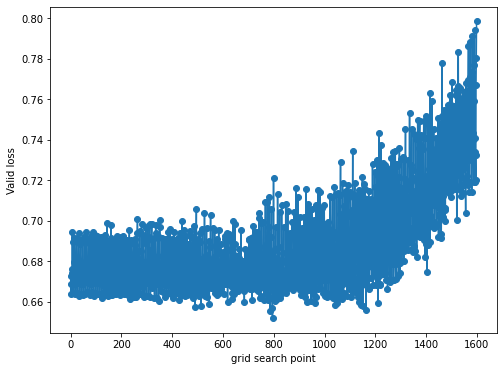

In [355]:
# Plot Loss vs point in grid search
data_out = 'data_xgb_04CrimeUnnormalized'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss01.csv'))
fig, axes = plt.subplots(figsize=(8,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid loss")
plt.show()

In [356]:
# Train with best hyperparameters
param[0] = ('eta', best_eta)
param[1] = ('max_depth', best_depth)

evals_result = {}
xgb_clf = xgb.train(param, dtrain, 
                    num_boost_round = 5000, 
                    evals = valid_list, 
                    early_stopping_rounds = 50, 
                    verbose_eval = True, 
                    evals_result=evals_result)

[0]	train-rmse:1.04755	valid-rmse:1.05205
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.98577	valid-rmse:0.99706
[2]	train-rmse:0.93102	valid-rmse:0.94959
[3]	train-rmse:0.88364	valid-rmse:0.91127
[4]	train-rmse:0.84085	valid-rmse:0.87531
[5]	train-rmse:0.80462	valid-rmse:0.84541
[6]	train-rmse:0.76941	valid-rmse:0.81702
[7]	train-rmse:0.73690	valid-rmse:0.79481
[8]	train-rmse:0.70976	valid-rmse:0.76982
[9]	train-rmse:0.68656	valid-rmse:0.75342
[10]	train-rmse:0.66290	valid-rmse:0.73741
[11]	train-rmse:0.64332	valid-rmse:0.72667
[12]	train-rmse:0.62448	valid-rmse:0.71692
[13]	train-rmse:0.60788	valid-rmse:0.70644
[14]	train-rmse:0.59215	valid-rmse:0.70077
[15]	train-rmse:0.57899	valid-rmse:0.69444
[16]	train-rmse:0.56876	valid-rmse:0.68833
[17]	train-rmse:0.55732	valid-rmse:0.68322
[18]	train-rmse:0.54753	valid-rmse:0.67870
[19]	train-rmse:0.53780	valid-rmse:0.67315
[20]	

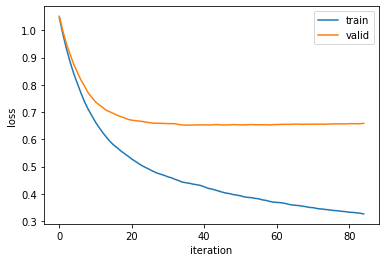

In [357]:
# Plot of train/valid loss vs iter
fig, axes = plt.subplots(figsize=(6,4))
axes.plot(evals_result['train']['rmse'], label="train")
axes.plot(evals_result['valid']['rmse'], label="valid")
axes.legend()
axes.set_ylabel("loss")
axes.set_xlabel("iteration")
# axes.set_xticks(np.arange(0, len(evals_result['train']['logloss']), 1))
plt.show()

In [358]:
# Save model and model's best params
data_out = 'data_xgb_04CrimeUnnormalized'
xgb_clf.save_model(os.path.join(data_out, 'xgb_model01.json'))
print("model saved at: '{}'".format(os.path.join(data_out, 'xgb_model01.json')))

best_params = {}
best_params['best_eta'] = best_eta
best_params['best_depth'] = int(best_depth)
with open(os.path.join(data_out, 'xgb_best_params01.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'xgb_best_params01.json')))

model saved at: 'data_xgb_04CrimeUnnormalized/xgb_model01.json'
best params saved at: 'data_xgb_04CrimeUnnormalized/xgb_best_params01.json'


In [359]:
# Save feature map
def ceate_feature_map(features, data_out):
    f = open(os.path.join(data_out, 'xgb_model_fmap01.txt'), 'w')
    i = 0
    for feat in features:
        f.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    f.close()

data_out = 'data_xgb_04CrimeUnnormalized'
ceate_feature_map(cols_all1, data_out)
print("feature map saved at: '{}'".format(os.path.join(data_out, 'xgb_model_fmap01.txt')))

feature map saved at: 'data_xgb_04CrimeUnnormalized/xgb_model_fmap01.txt'


In [360]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_xgb_04CrimeUnnormalized'
model = xgb.Booster(model_file=os.path.join(data_out, 'xgb_model01.json'))
df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['mse', 'r2'])

ypred = model.predict(dtrain)
df_results.loc['train', 'mse'] = mean_squared_error(ytrain, ypred, squared=True)
df_results.loc['train', 'r2']   = r2_score(ytrain, ypred)

ypred = model.predict(dvalid)
df_results.loc['valid', 'mse'] = mean_squared_error(yvalid, ypred, squared=True)
df_results.loc['valid', 'r2']   = r2_score(yvalid, ypred)

ypred = model.predict(dtest)
df_results.loc['test', 'mse'] = mean_squared_error(ytest, ypred, squared=True)
df_results.loc['test', 'r2']   = r2_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_xgb01.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_xgb01.csv')))
df_results.head()

model results saved at: 'data_xgb_04CrimeUnnormalized/results_target_xgb01.csv'


,mse,r2
train,0.105017,0.894983
valid,0.434618,0.545479
test,0.404822,0.511957


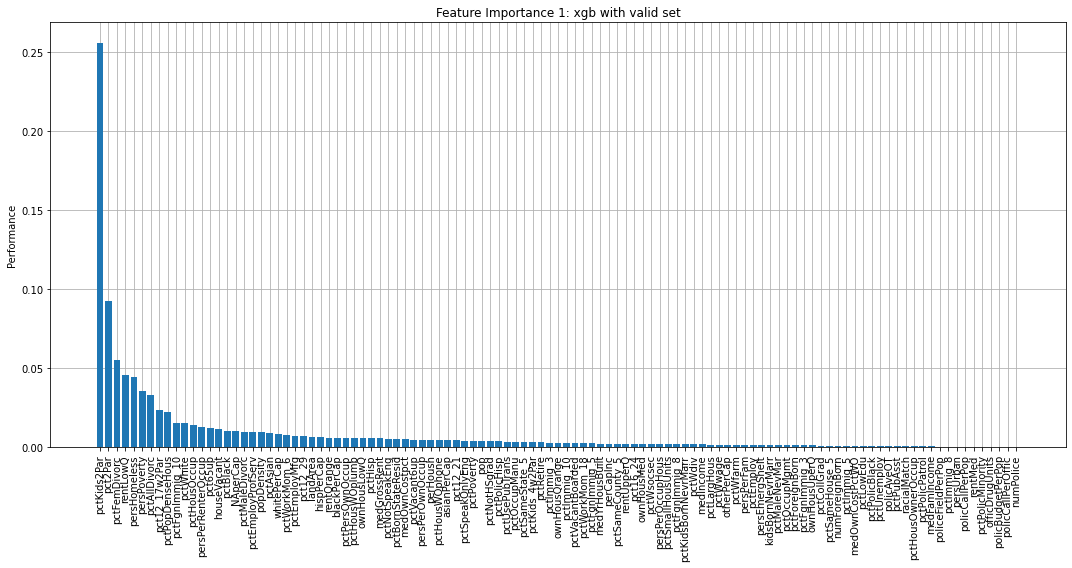

feature importance graph saved at: 'data_xgb_04CrimeUnnormalized/feature_importance_xgb01.pdf'
feature importance .csv saved at: 'data_xgb_04CrimeUnnormalized/feature_importance_xgb01.csv'


In [361]:
# Plot/save feature importance
data_out = 'data_xgb_04CrimeUnnormalized'
model = xgb.Booster(model_file=os.path.join(data_out, 'xgb_model01.json'))

importance = pd.DataFrame.from_dict(model.get_score(fmap=os.path.join(data_out, 'xgb_model_fmap01.txt'), 
                                                    importance_type="total_gain"), 
                                    orient='index')
importance.columns = ["score"]
importance_sorted = importance.sort_values(by=["score"], ascending=False)
importance_sorted = importance_sorted/importance_sorted.sum()

fig, axes = plt.subplots(figsize=(15,8))
x_pos = np.arange(len(importance_sorted))
axes.bar(x_pos, importance_sorted["score"], zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(importance_sorted.index, rotation='vertical')
axes.set_ylabel('Performance')
axes.set_title('Feature Importance 1: xgb with valid set')
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance_xgb01.pdf'), bbox_inches='tight')
plt.show()
print("feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance_xgb01.pdf')))

importance_sorted.to_csv(os.path.join(data_out, 'feature_importance_xgb01.csv'))
print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_xgb01.csv')))

In [368]:
# Find Accuracy +/- STD
data_out = 'data_xgb_04CrimeUnnormalized'
df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
                                   'train_r2', 'valid_r2', 'test_r2'])

with open(os.path.join(data_out, 'xgb_best_params01.json')) as f:
    best_params = json.load(f)
param = [('eta', best_params['best_eta']), 
         ('max_depth', best_params['best_depth']), 
         ('objective', 'reg:squarederror'), 
         ('nthread', 16),
         ('eval_metric', 'rmse')
]

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_04CrimeUnnormalized/X1.csv')
    y = pd.read_csv('dataset_04CrimeUnnormalized/y1.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .normalize data sets
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xvalid = scaler.transform(xvalid)
    xtest  = scaler.transform(xtest)

    scaler = StandardScaler()
    scaler.fit(ytrain)
    ytrain = scaler.transform(ytrain)
    yvalid = scaler.transform(yvalid)
    ytest  = scaler.transform(ytest)
    
# .build DMatrices
    dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=16)
    dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=16)
    dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=16)
    valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

# .train model
    evals_result = {}
    model = xgb.train(param, dtrain, 
                      num_boost_round = 5000, 
                      evals = valid_list, 
                      early_stopping_rounds = 20, 
                      verbose_eval = False, 
                      evals_result=evals_result)
    
# .compute/save accuracy
    ypred = model.predict(dtrain)
    df_results.loc[n, 'train_mse'] = mean_squared_error(ytrain, ypred, squared=True)
    df_results.loc[n, 'train_r2']   = r2_score(ytrain, ypred)

    ypred = model.predict(dvalid)
    df_results.loc[n, 'valid_mse'] = mean_squared_error(yvalid, ypred, squared=True)
    df_results.loc[n, 'valid_r2']   = r2_score(yvalid, ypred)

    ypred = model.predict(dtest)
    df_results.loc[n, 'test_mse'] = mean_squared_error(ytest, ypred, squared=True)
    df_results.loc[n, 'test_r2']   = r2_score(ytest, ypred)

    model.save_model(os.path.join(data_out, 'xgb_model01_'+str(n)+'.json'))
    df_results.to_csv(os.path.join(data_out, 'accuracy_xgb01.csv'), index=None)

In [369]:
# Display results
data_out = 'data_xgb_04CrimeUnnormalized'
accuracy_xgb = pd.read_csv(os.path.join(data_out, 'accuracy_xgb01.csv'))
print("Train mse = {:.3f} +/- {:.3f}".format(accuracy_xgb['train_mse'].mean(), 
                                              accuracy_xgb['train_mse'].std()))
print("Valid mse = {:.3f} +/- {:.3f}".format(accuracy_xgb['valid_mse'].mean(), 
                                              accuracy_xgb['valid_mse'].std()))
print("Test mse = {:.3f} +/- {:.3f}".format(accuracy_xgb['test_mse'].mean(), 
                                             accuracy_xgb['test_mse'].std()))

print("")
print("Train r2 = {:.3f} +/- {:.3f}".format(accuracy_xgb['train_r2'].mean(), 
                                            accuracy_xgb['train_r2'].std()))
print("Valid r2 = {:.3f} +/- {:.3f}".format(accuracy_xgb['valid_r2'].mean(), 
                                            accuracy_xgb['valid_r2'].std()))
print("Test r2 = {:.3f} +/- {:.3f}".format(accuracy_xgb['test_r2'].mean(), 
                                           accuracy_xgb['test_r2'].std()))

Train mse = 0.119 +/- 0.028
Valid mse = 0.489 +/- 0.123
Test mse = 0.477 +/- 0.105

Train r2 = 0.881 +/- 0.028
Valid r2 = 0.514 +/- 0.061
Test r2 = 0.525 +/- 0.054


* ### Lockout

In [25]:
# Normalize Data Set
def normalize_data():
    """
    """
    global xtrain, xvalid, xtest, ytrain, yvalid, ytest
    scaler = StandardScaler()
    scaler.fit(xtrain.numpy())
    xtrain = torch.from_numpy(scaler.transform(xtrain.numpy()))
    xvalid = torch.from_numpy(scaler.transform(xvalid.numpy()))
    xtest = torch.from_numpy(scaler.transform(xtest.numpy()))
    
    scaler = StandardScaler()
    scaler.fit(ytrain.numpy())
    ytrain = torch.from_numpy(scaler.transform(ytrain.numpy()))
    yvalid = torch.from_numpy(scaler.transform(yvalid.numpy()))
    ytest = torch.from_numpy(scaler.transform(ytest.numpy()))

In [26]:
# Save output data
def save_output(data_out, f1, f2, f3, new_folder=False):
    """
    """
# Save relevant data
    if new_folder == True:
        dirs = os.listdir()
        if data_out in dirs:
            print("'{}' directory deleted.".format(data_out))
            shutil.rmtree(data_out)
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
        else:
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
# 
    train_loss.to_csv(os.path.join(data_out, f1), index=False)
    valid_loss.to_csv(os.path.join(data_out, f2), index=False)
    print("'{}' saved.".format(f1))
    print("'{}' saved.".format(f2))

    for m in f3:
        shutil.move(m, os.path.join(data_out, m))
        print("'{}' saved.".format(m))

* #### Target 1: l1=5, l2=1; lockout=l1

In [27]:
# Set layers where lockdown is to be applied
def get_lockdown_layers(model):
    layers = [model.classifier[0]]
    return layers

In [28]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [10]:
# Grid search space
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_mse', 'valid_r2'], 
                            index=range(len(grid_lrs)))

In [22]:
# Perform grid search (unconstrained)
layer_sizes = [5, 1]
epochs = 50000
data_in = 'dataset_04CrimeUnnormalized'
data_out = "data_unconstrained_04CrimeUnnormalized/lrs"
lock_flag = False

# Read data
load_data(data_in, i=1)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    fname = 'model04_forward01_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss01_'+str(n)+'.csv', 
                'valid_loss01_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel())

# .save grid search results
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], mse, r2]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_forward01.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


lr-grid loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00050
-Model saved after iteration 19502.
-Train.  Loss=0.3900676
-Valid.  Loss=0.4102198

Best train loss = 0.3413342

'train_loss01_1.csv' saved.
'valid_loss01_1.csv' saved.
'model04_forward01_1_last.pth' saved.
'model04_forward01_1_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00090
-Model saved after iteration 10840.
-Train.  Loss=0.3900068
-Valid.  Loss=0.4102201

Best train loss = 0.3051211

'train_loss01_2.csv' saved.
'valid_loss01_2.csv' saved.
'model04_forward01_2_last.pth' saved.
'model04_forward01_2_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-Model saved after iteration 6024.
-Train.  Loss=0.3899611
-Valid.  Loss=0.4102168

Best train loss = 0.2739020

'train_loss01_3.csv' saved.
'valid_loss01_3.csv' saved.
'model04_forward01_3_last.pth' saved.
'model04_forward01_3_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 3343.
-Train.  Loss=0.3899262
-Valid.  Loss=0.4102425

Best train loss = 0.2535950

'train_loss01_4.csv' saved.
'valid_loss01_4.csv' saved.
'model04_forward01_4_last.pth' saved.
'model04_forward01_4_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 1859.
-Train.  Loss=0.3898750
-Valid.  Loss=0.4102369

Best train loss = 0.2343829

'train_loss01_5.csv' saved.
'valid_loss01_5.csv' saved.
'model04_forward01_5_last.pth' saved.
'model04_forward01_5_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00949
-Model saved after iteration 1031.
-Train.  Loss=0.3899476
-Valid.  Loss=0.4102698

Best train loss = 0.2104113

'train_loss01_6.csv' saved.
'valid_loss01_6.csv' saved.
'model04_forward01_6_last.pth' saved.
'model04_forward01_6_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01710
-Model saved after iteration 569.
-Train.  Loss=0.3902786
-Valid.  Loss=0.4103051

Best train loss = 0.2034352

'train_loss01_7.csv' saved.
'valid_loss01_7.csv' saved.
'model04_forward01_7_last.pth' saved.
'model04_forward01_7_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.03081
-Model saved after iteration 320.
-Train.  Loss=0.3898690
-Valid.  Loss=0.4103854

Best train loss = 0.1976209

'train_loss01_8.csv' saved.
'valid_loss01_8.csv' saved.
'model04_forward01_8_last.pth' saved.
'model04_forward01_8_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 175.
-Train.  Loss=0.3908656
-Valid.  Loss=0.4106036

Best train loss = 0.1941070

'train_loss01_9.csv' saved.
'valid_loss01_9.csv' saved.
'model04_forward01_9_last.pth' saved.
'model04_forward01_9_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-Model saved after iteration 94.
-Train.  Loss=0.3931081
-Valid.  Loss=0.4113090

Best train loss = 0.2001259

'train_loss01_10.csv' saved.
'valid_loss01_10.csv' saved.
'model04_forward01_10_last.pth' saved.
'model04_forward01_10_best.pth' saved.


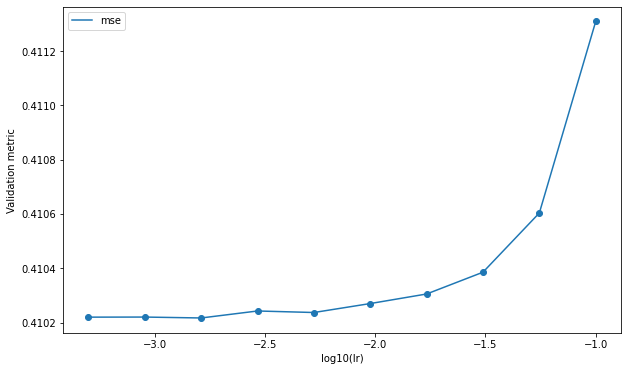

In [23]:
# Plot Loss vs point in grid search
data_out = "data_unconstrained_04CrimeUnnormalized/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward01.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_mse'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_mse'], label='mse')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [18]:
# Display grid search results
data_out = "data_unconstrained_04CrimeUnnormalized/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward01.csv'))

idx = df_grid_loss.valid_mse.idxmin()
best_lr_fward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_fward))
print("- Best valid mse = {}".format(best_mse))

# Copy best model to main directory
shutil.copy("data_unconstrained_04CrimeUnnormalized/lrs/model04_forward01_"+str(idx+1)+"_best.pth", 
            "data_unconstrained_04CrimeUnnormalized/model04_forward01_best.pth")
shutil.copy("data_unconstrained_04CrimeUnnormalized/lrs/model04_forward01_"+str(idx+1)+"_last.pth", 
            "data_unconstrained_04CrimeUnnormalized/model04_forward01_last.pth")
shutil.copy("data_unconstrained_04CrimeUnnormalized/lrs/train_loss01_"+str(idx+1)+".csv", 
            "data_unconstrained_04CrimeUnnormalized/train_loss01.csv")
shutil.copy("data_unconstrained_04CrimeUnnormalized/lrs/valid_loss01_"+str(idx+1)+".csv", 
            "data_unconstrained_04CrimeUnnormalized/valid_loss01.csv")

Best parameters (3):
- Best lr = 0.00162
- Best valid mse = 0.41021672


'data_unconstrained_04CrimeUnnormalized/valid_loss01.csv'

In [27]:
# Grid search space
target_idx = 1
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_mse', 'valid_r2'], 
                            index=range(len(grid_lrs)))

In [28]:
# Perform grid search (lockdown)
layer_sizes = [5, 1]
epochs = 20000
data_in = 'dataset_04CrimeUnnormalized'
data_out = "data_lockdown_04CrimeUnnormalized/lrs"
step = 1
lock_flag = True

# Read data
load_data(data_in, i=1)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    model_forward_name = 'data_unconstrained_04CrimeUnnormalized/model04_forward01_last.pth'
    fname = 'model04_backward01_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss01_'+str(n)+'.csv', 
                'valid_loss01_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel())

# .save grid search results
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], mse, r2]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_backward01.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


lr-grid loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00050
-Model saved after iteration 17081.
-Train.  Loss=0.3790716
-Valid.  Loss=0.3950028

Best train loss = 0.2721075

'train_loss01_1.csv' saved.
'valid_loss01_1.csv' saved.
'model04_backward01_1_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00090
-Model saved after iteration 18550.
-Train.  Loss=0.4134756
-Valid.  Loss=0.3887308

Best train loss = 0.2722311

'train_loss01_2.csv' saved.
'valid_loss01_2.csv' saved.
'model04_backward01_2_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-Model saved after iteration 18296.
-Train.  Loss=0.3981207
-Valid.  Loss=0.3856152

Best train loss = 0.2722048

'train_loss01_3.csv' saved.
'valid_loss01_3.csv' saved.
'model04_backward01_3_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18618.
-Train.  Loss=0.4004988
-Valid.  Loss=0.3825742

Best train loss = 0.2739146

'train_loss01_4.csv' saved.
'valid_loss01_4.csv' saved.
'model04_backward01_4_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 19056.
-Train.  Loss=0.4186000
-Valid.  Loss=0.3847483

Best train loss = 0.2739146

'train_loss01_5.csv' saved.
'valid_loss01_5.csv' saved.
'model04_backward01_5_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00949
-Model saved after iteration 19429.
-Train.  Loss=0.4593709
-Valid.  Loss=0.3936514

Best train loss = 0.2739146

'train_loss01_6.csv' saved.
'valid_loss01_6.csv' saved.
'model04_backward01_6_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01710
-Model saved after iteration 19123.
-Train.  Loss=0.4336030
-Valid.  Loss=0.3932383

Best train loss = 0.2739146

'train_loss01_7.csv' saved.
'valid_loss01_7.csv' saved.
'model04_backward01_7_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.03081
-Model saved after iteration 18554.
-Train.  Loss=0.4472257
-Valid.  Loss=0.3947757

Best train loss = 0.2739146

'train_loss01_8.csv' saved.
'valid_loss01_8.csv' saved.
'model04_backward01_8_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 16740.
-Train.  Loss=0.4471958
-Valid.  Loss=0.3862556

Best train loss = 0.2739146

'train_loss01_9.csv' saved.
'valid_loss01_9.csv' saved.
'model04_backward01_9_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-Model saved after iteration 33.
-Train.  Loss=0.4227209
-Valid.  Loss=0.3943108

Best train loss = 0.2739146

'train_loss01_10.csv' saved.
'valid_loss01_10.csv' saved.
'model04_backward01_10_best.pth' saved.


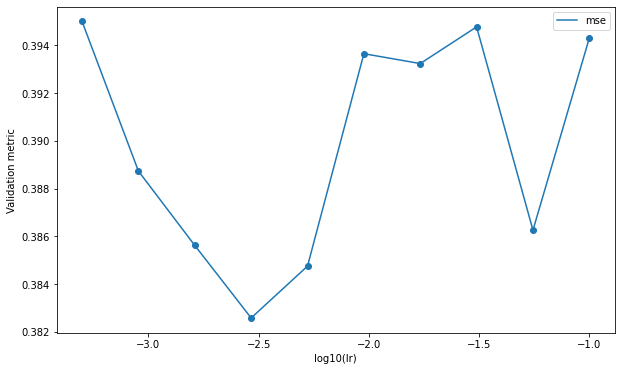

In [29]:
# Plot Loss vs point in grid search
data_out = "data_lockdown_04CrimeUnnormalized/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward01.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_mse'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_mse'], label='mse')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [19]:
# Display grid search results
data_out = "data_lockdown_04CrimeUnnormalized/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward01.csv'))

idx = df_grid_loss.valid_mse.idxmin()
best_lr_bward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_bward))
print("- Best valid mse = {}".format(best_mse))

# Copy best models to main directory
shutil.copy("data_unconstrained_04CrimeUnnormalized/lrs/model04_forward01_"+str(idx+1)+"_best.pth", 
            "data_lockdown_04CrimeUnnormalized/model04_fward01_best.pth")
shutil.copy("data_unconstrained_04CrimeUnnormalized/lrs/model04_forward01_"+str(idx+1)+"_last.pth", 
            "data_lockdown_04CrimeUnnormalized/model04_fward01_last.pth")
shutil.copy("data_lockdown_04CrimeUnnormalized/lrs/model04_backward01_"+str(idx+1)+"_best.pth", 
            "data_lockdown_04CrimeUnnormalized/model04_backward01_best.pth")

shutil.copy("data_unconstrained_04CrimeUnnormalized/lrs/train_loss01_"+str(idx+1)+".csv", 
            "data_lockdown_04CrimeUnnormalized/train_loss_fward01.csv")
shutil.copy("data_unconstrained_04CrimeUnnormalized/lrs/valid_loss01_"+str(idx+1)+".csv", 
            "data_lockdown_04CrimeUnnormalized/valid_loss_fward01.csv")
shutil.copy("data_lockdown_04CrimeUnnormalized/lrs/train_loss01_"+str(idx+1)+".csv", 
            "data_lockdown_04CrimeUnnormalized/train_loss01.csv")
shutil.copy("data_lockdown_04CrimeUnnormalized/lrs/valid_loss01_"+str(idx+1)+".csv", 
            "data_lockdown_04CrimeUnnormalized/valid_loss01.csv")

Best parameters (4):
- Best lr = 0.00292
- Best valid mse = 0.38257414


'data_lockdown_04CrimeUnnormalized/valid_loss01.csv'

In [35]:
# Find MSE, R2, etc...
data_out = "data_lockdown_04CrimeUnnormalized"
index = pd.MultiIndex.from_product([['TRAIN', 'VALIDATION', 'TEST'], ['forward', 'lockdown']])
df_results = pd.DataFrame(index=index, columns=['MSE', 'R2'])

# Load/normalize data
load_data('dataset_04CrimeUnnormalized', i=1)
normalize_data()

# Unconstrained results
layer_sizes = [5, 1]
features = xtrain.size(1)
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_unconstrained_04CrimeUnnormalized/model04_forward01_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
mse = mean_squared_error(ytrain.detach().numpy(), ypred.detach().numpy())
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
df_results.loc[('TRAIN', 'forward'), 'MSE'] = mse
df_results.loc[('TRAIN', 'forward'), 'R2'] = r2

ypred = mm(xvalid)
mse = mean_squared_error(yvalid.detach().numpy(), ypred.detach().numpy())
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
df_results.loc[('VALIDATION', 'forward'), 'MSE'] = mse
df_results.loc[('VALIDATION', 'forward'), 'R2'] = r2

ypred = mm(xtest)
mse = mean_squared_error(ytest.detach().numpy(), ypred.detach().numpy())
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
df_results.loc[('TEST', 'forward'), 'MSE'] = mse
df_results.loc[('TEST', 'forward'), 'R2'] = r2

# Lockdown results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_lockdown_04CrimeUnnormalized/model04_backward01_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
mse = mean_squared_error(ytrain.detach().numpy(), ypred.detach().numpy())
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
df_results.loc[('TRAIN', 'lockdown'), 'MSE'] = mse
df_results.loc[('TRAIN', 'lockdown'), 'R2'] = r2

ypred = mm(xvalid)
mse = mean_squared_error(yvalid.detach().numpy(), ypred.detach().numpy())
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
df_results.loc[('VALIDATION', 'lockdown'), 'MSE'] = mse
df_results.loc[('VALIDATION', 'lockdown'), 'R2'] = r2

ypred = mm(xtest)
mse = mean_squared_error(ytest.detach().numpy(), ypred.detach().numpy())
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
df_results.loc[('TEST', 'lockdown'), 'MSE'] = mse
df_results.loc[('TEST', 'lockdown'), 'R2'] = r2

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_lockdown01.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_lockdown01.csv')))
df_results

model results saved at: 'data_lockdown_04CrimeUnnormalized/results_target_lockdown01.csv'


MSE        R2
TRAIN      forward   0.389961  0.610039
           lockdown  0.400499  0.599501
VALIDATION forward   0.410217  0.570997
           lockdown  0.382574  0.599906
TEST       forward   0.332904   0.59866
           lockdown  0.307424  0.629378

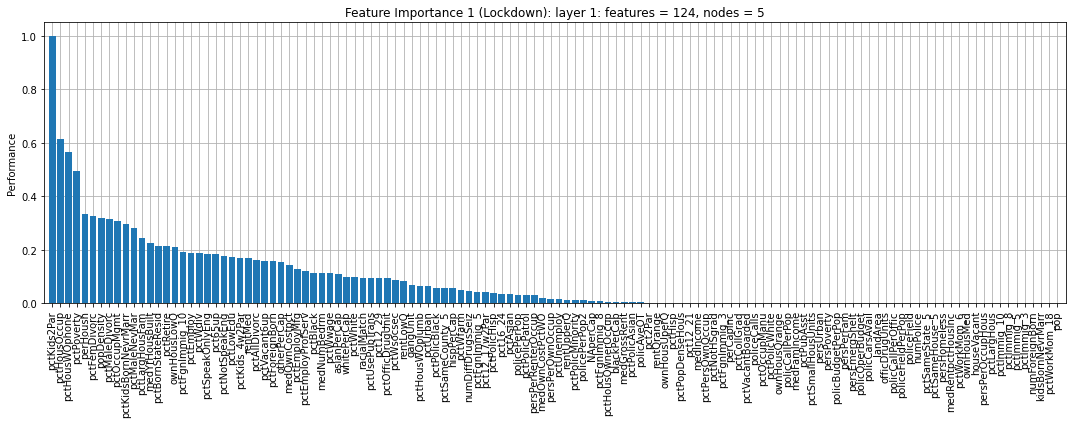

Feature importance graph saved at: 'data_lockdown_04CrimeUnnormalized/feature_importance_target1.pdf'
feature importance .csv saved at: 'data_lockdown_04CrimeUnnormalized/feature_importance_lockdown01.csv'


In [49]:
# Weight importance (Lockdown: layer 1)
data_out = "data_lockdown_04CrimeUnnormalized"
mm = torch.load('data_lockdown_04CrimeUnnormalized/model04_backward01_best.pth')
feature_importance1 = pd.Series(abs(mm['classifier.0.weight']).sum(dim=0), index=cols_all1)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

idx = feature_importance_sorted1 >= 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx.sum())
axes.bar(x_pos, feature_importance_sorted1[idx], zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Performance')
axes.set_title('Feature Importance 1 (Lockdown): layer 1: features = {}, nodes = {}'.format(features, 
                                                                                            layer_sizes[0]))
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance_target1.pdf'), bbox_inches='tight')
plt.show()
print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance_target1.pdf')))

feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_lockdown01.csv'))
print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_lockdown01.csv')))

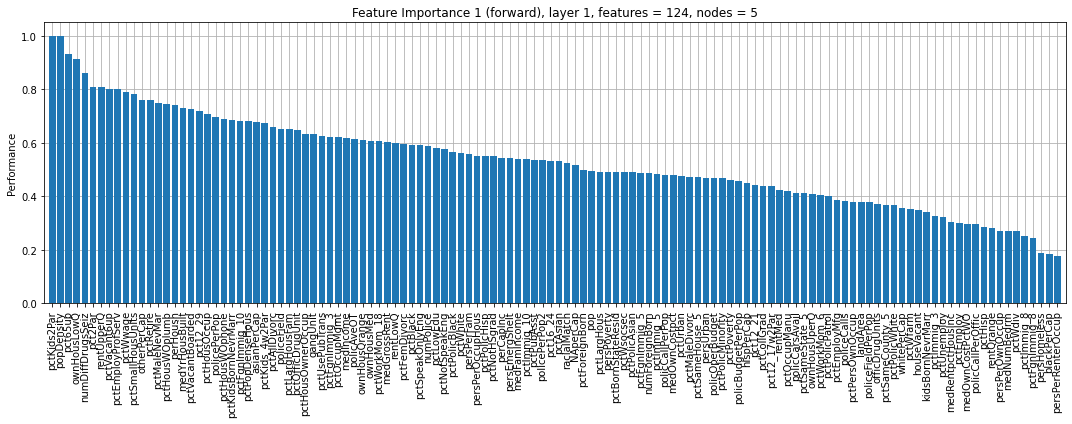

Feature importance graph saved at: 'data_unconstrained_04CrimeUnnormalized/feature_importance_target1.pdf'
feature importance .csv saved at: 'data_unconstrained_04CrimeUnnormalized/feature_importance_forward01.csv'


In [50]:
# Weight importance (Forward: layer 1)
data_out = "data_unconstrained_04CrimeUnnormalized"
mm = torch.load('data_unconstrained_04CrimeUnnormalized/model04_forward01_best.pth')
feature_importance1 = pd.Series(abs(mm['classifier.0.weight']).sum(dim=0), index=cols_all1)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

idx = feature_importance_sorted1 >= 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx.sum())
axes.bar(x_pos, feature_importance_sorted1[idx], zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Performance')
axes.set_title('Feature Importance 1 (forward), layer 1, features = {}, nodes = {}'.format(features, 
                                                                                           layer_sizes[0]))
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance_target1.pdf'), bbox_inches='tight')
plt.show()
print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance_target1.pdf')))

feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_forward01.csv'))
print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_forward01.csv')))

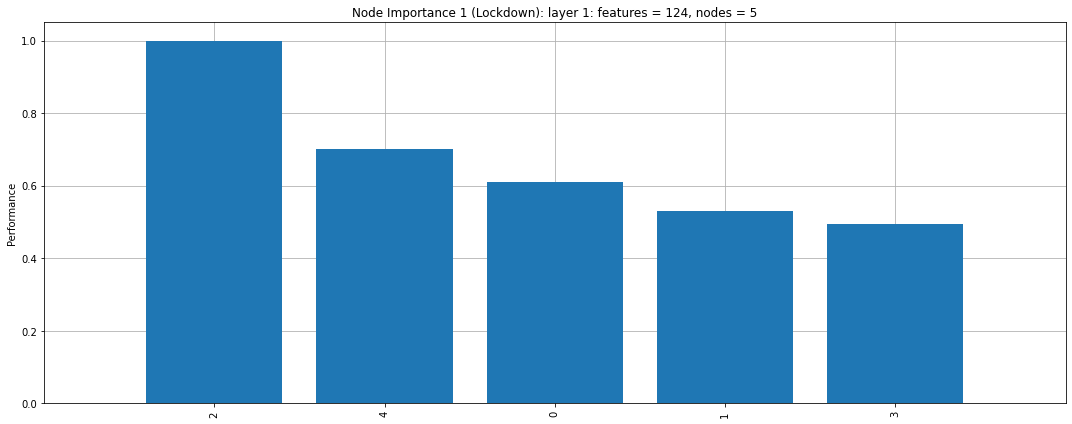

'node_importance01_l1_target1.pdf' file saved.



In [51]:
# Node importance (Lockdown: layer 1)
mm = torch.load('data_lockdown_04CrimeUnnormalized/model04_backward01_best.pth')
feature_importance1 = pd.Series(abs(mm['classifier.0.weight']).sum(dim=1), index=range(layer_sizes[0]))
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(layer_sizes[0])
axes.bar(x_pos, feature_importance_sorted1, zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(feature_importance_sorted1.index, rotation='vertical')
axes.set_xlim(-1,5)
axes.set_ylabel('Performance')
axes.set_title('Node Importance 1 (Lockdown): layer 1: features = {}, nodes = {}'.format(features, 
                                                                                            layer_sizes[0]))
axes.grid(True, zorder=1)

plt.tight_layout()
# plt.savefig('data_lockdown_04CrimeUnnormalized/node_importance01_l1_target1.pdf', bbox_inches='tight')
plt.show()
print("'{}' file saved.\n".format('node_importance01_l1_target1.pdf'))

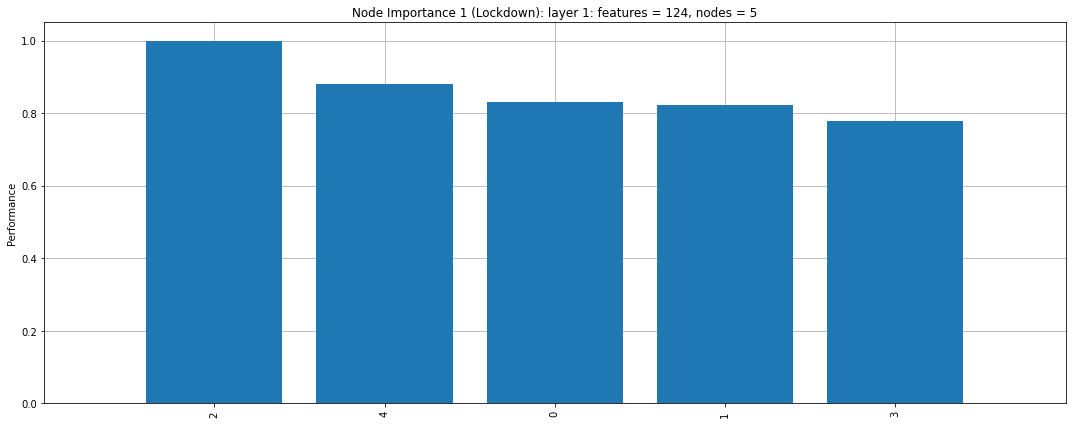

'node_importance01_l1_target1.pdf' file saved.



In [52]:
# Node importance (Forward: layer 1)
mm = torch.load('data_unconstrained_04CrimeUnnormalized/model04_forward01_best.pth')
feature_importance1 = pd.Series(abs(mm['classifier.0.weight']).sum(dim=1), index=range(layer_sizes[0]))
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(layer_sizes[0])
axes.bar(x_pos, feature_importance_sorted1, zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(feature_importance_sorted1.index, rotation='vertical')
axes.set_xlim(-1,5)
axes.set_ylabel('Performance')
axes.set_title('Node Importance 1 (Lockdown): layer 1: features = {}, nodes = {}'.format(features, 
                                                                                            layer_sizes[0]))
axes.grid(True, zorder=1)

plt.tight_layout()
# plt.savefig('data_lockdown_04CrimeUnnormalized/node_importance01_l1_target1.pdf', bbox_inches='tight')
plt.show()
print("'{}' file saved.\n".format('node_importance01_l1_target1.pdf'))

In [56]:
# Find Accuracy, Loss +/- STD (Forward)
data_output = 'data_unconstrained_04CrimeUnnormalized'
df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
                                   'train_r2', 'valid_r2', 'test_r2'])
# df_results = pd.read_csv(os.path.join(data_output, 'accuracy_forward01.csv'), index_col=0)

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_04CrimeUnnormalized/X1.csv')
    y = pd.read_csv('dataset_04CrimeUnnormalized/y1.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_fward
    layer_sizes = [5, 1]
    epochs = 50000
    data_out = "data_unconstrained_04CrimeUnnormalized/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model04_forward01_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = 10000, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss01_'+str(n)+'.csv', 
                'valid_loss01_'+str(n)+'.csv', f3)

# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    mse = mean_squared_error(ytrain.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytrain.detach().numpy().ravel(), ypred.detach().numpy().ravel())
    df_results.loc[n, 'train_mse'] = mse
    df_results.loc[n, 'train_r2']  = r2

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel())
    df_results.loc[n, 'valid_mse'] = mse
    df_results.loc[n, 'valid_r2']  = r2

    ypred = mm(xtest)
    mse = mean_squared_error(ytest.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytest.detach().numpy().ravel(), ypred.detach().numpy().ravel())
    df_results.loc[n, 'test_mse'] = mse
    df_results.loc[n, 'test_r2']  = r2

    df_results.to_csv(os.path.join(data_output, 'accuracy04_forward01.csv'), index=True)


Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1086.
-Train.  Loss=0.4778516
-Valid.  Loss=0.4640983
'train_loss01_1.csv' saved.
'valid_loss01_1.csv' saved.
'model04_forward01_1_last.pth' saved.
'model04_forward01_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4172.
-Train.  Loss=0.4305381
-Valid.  Loss=0.2916986
'train_loss01_2.csv' saved.
'valid_loss01_2.csv' saved.
'model04_forward01_2_last.pth' saved.
'model04_forward01_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7016.
-Train.  Loss=0.3801305
-Valid.  Loss=0.5432960
'train_loss01_3.csv' saved.
'valid_loss01_3.csv' saved.
'model04_forward01_3_last.pth' saved.
'model04_forward01_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2864.
-Train.  Loss=0.3862806
-Valid.  Loss=0.4678721
'train_loss01_4.csv' saved.
'valid_loss01_4.csv' saved.
'model04_forward01_4_last.pth' saved.
'model04_forward01_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5801.
-Train.  Loss=0.3967461
-Valid.  Loss=0.4055498
'train_loss01_5.csv' saved.
'valid_loss01_5.csv' saved.
'model04_forward01_5_last.pth' saved.
'model04_forward01_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5740.
-Train.  Loss=0.3850360
-Valid.  Loss=0.3609324
'train_loss01_6.csv' saved.
'valid_loss01_6.csv' saved.
'model04_forward01_6_last.pth' saved.
'model04_forward01_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2902.
-Train.  Loss=0.4197290
-Valid.  Loss=0.4077169
'train_loss01_7.csv' saved.
'valid_loss01_7.csv' saved.
'model04_forward01_7_last.pth' saved.
'model04_forward01_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3221.
-Train.  Loss=0.3901775
-Valid.  Loss=0.4012694
'train_loss01_8.csv' saved.
'valid_loss01_8.csv' saved.
'model04_forward01_8_last.pth' saved.
'model04_forward01_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2919.
-Train.  Loss=0.4081683
-Valid.  Loss=0.4819656
'train_loss01_9.csv' saved.
'valid_loss01_9.csv' saved.
'model04_forward01_9_last.pth' saved.
'model04_forward01_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3128.
-Train.  Loss=0.3525992
-Valid.  Loss=0.6416106
'train_loss01_10.csv' saved.
'valid_loss01_10.csv' saved.
'model04_forward01_10_last.pth' saved.
'model04_forward01_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2028.
-Train.  Loss=0.4379571
-Valid.  Loss=0.3521275
'train_loss01_11.csv' saved.
'valid_loss01_11.csv' saved.
'model04_forward01_11_last.pth' saved.
'model04_forward01_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2505.
-Train.  Loss=0.4087819
-Valid.  Loss=0.5249534
'train_loss01_12.csv' saved.
'valid_loss01_12.csv' saved.
'model04_forward01_12_last.pth' saved.
'model04_forward01_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 15063.
-Train.  Loss=0.3426885
-Valid.  Loss=0.3488215
'train_loss01_13.csv' saved.
'valid_loss01_13.csv' saved.
'model04_forward01_13_last.pth' saved.
'model04_forward01_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6151.
-Train.  Loss=0.3485929
-Valid.  Loss=0.6391482
'train_loss01_14.csv' saved.
'valid_loss01_14.csv' saved.
'model04_forward01_14_last.pth' saved.
'model04_forward01_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4443.
-Train.  Loss=0.3953313
-Valid.  Loss=0.5182288
'train_loss01_15.csv' saved.
'valid_loss01_15.csv' saved.
'model04_forward01_15_last.pth' saved.
'model04_forward01_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4779.
-Train.  Loss=0.4194018
-Valid.  Loss=0.3498538
'train_loss01_16.csv' saved.
'valid_loss01_16.csv' saved.
'model04_forward01_16_last.pth' saved.
'model04_forward01_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3144.
-Train.  Loss=0.3538521
-Valid.  Loss=0.6405351
'train_loss01_17.csv' saved.
'valid_loss01_17.csv' saved.
'model04_forward01_17_last.pth' saved.
'model04_forward01_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 910.
-Train.  Loss=0.4346052
-Valid.  Loss=0.5334011
'train_loss01_18.csv' saved.
'valid_loss01_18.csv' saved.
'model04_forward01_18_last.pth' saved.
'model04_forward01_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5245.
-Train.  Loss=0.3816639
-Valid.  Loss=0.3976313
'train_loss01_19.csv' saved.
'valid_loss01_19.csv' saved.
'model04_forward01_19_last.pth' saved.
'model04_forward01_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2586.
-Train.  Loss=0.3797729
-Valid.  Loss=0.6619277
'train_loss01_20.csv' saved.
'valid_loss01_20.csv' saved.
'model04_forward01_20_last.pth' saved.
'model04_forward01_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6926.
-Train.  Loss=0.3470893
-Valid.  Loss=0.6095698
'train_loss01_21.csv' saved.
'valid_loss01_21.csv' saved.
'model04_forward01_21_last.pth' saved.
'model04_forward01_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 14815.
-Train.  Loss=0.3333492
-Valid.  Loss=0.5238968
'train_loss01_22.csv' saved.
'valid_loss01_22.csv' saved.
'model04_forward01_22_last.pth' saved.
'model04_forward01_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7511.
-Train.  Loss=0.3775466
-Valid.  Loss=0.3450650
'train_loss01_23.csv' saved.
'valid_loss01_23.csv' saved.
'model04_forward01_23_last.pth' saved.
'model04_forward01_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6337.
-Train.  Loss=0.3326273
-Valid.  Loss=0.3767577
'train_loss01_24.csv' saved.
'valid_loss01_24.csv' saved.
'model04_forward01_24_last.pth' saved.
'model04_forward01_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1126.
-Train.  Loss=0.4171396
-Valid.  Loss=0.5994126
'train_loss01_25.csv' saved.
'valid_loss01_25.csv' saved.
'model04_forward01_25_last.pth' saved.
'model04_forward01_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6897.
-Train.  Loss=0.3554920
-Valid.  Loss=0.4081435
'train_loss01_26.csv' saved.
'valid_loss01_26.csv' saved.
'model04_forward01_26_last.pth' saved.
'model04_forward01_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5257.
-Train.  Loss=0.3949449
-Valid.  Loss=0.4208395
'train_loss01_27.csv' saved.
'valid_loss01_27.csv' saved.
'model04_forward01_27_last.pth' saved.
'model04_forward01_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 9100.
-Train.  Loss=0.3268467
-Valid.  Loss=0.4805458
'train_loss01_28.csv' saved.
'valid_loss01_28.csv' saved.
'model04_forward01_28_last.pth' saved.
'model04_forward01_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3534.
-Train.  Loss=0.3563104
-Valid.  Loss=0.6190776
'train_loss01_29.csv' saved.
'valid_loss01_29.csv' saved.
'model04_forward01_29_last.pth' saved.
'model04_forward01_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 8484.
-Train.  Loss=0.3323335
-Valid.  Loss=0.5369825
'train_loss01_30.csv' saved.
'valid_loss01_30.csv' saved.
'model04_forward01_30_last.pth' saved.
'model04_forward01_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6725.
-Train.  Loss=0.3153169
-Valid.  Loss=0.5546482
'train_loss01_31.csv' saved.
'valid_loss01_31.csv' saved.
'model04_forward01_31_last.pth' saved.
'model04_forward01_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3232.
-Train.  Loss=0.4151506
-Valid.  Loss=0.3684830
'train_loss01_32.csv' saved.
'valid_loss01_32.csv' saved.
'model04_forward01_32_last.pth' saved.
'model04_forward01_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2474.
-Train.  Loss=0.4150427
-Valid.  Loss=0.4725018
'train_loss01_33.csv' saved.
'valid_loss01_33.csv' saved.
'model04_forward01_33_last.pth' saved.
'model04_forward01_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5916.
-Train.  Loss=0.3798234
-Valid.  Loss=0.3995762
'train_loss01_34.csv' saved.
'valid_loss01_34.csv' saved.
'model04_forward01_34_last.pth' saved.
'model04_forward01_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 9687.
-Train.  Loss=0.3196104
-Valid.  Loss=0.3980752
'train_loss01_35.csv' saved.
'valid_loss01_35.csv' saved.
'model04_forward01_35_last.pth' saved.
'model04_forward01_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6196.
-Train.  Loss=0.3778460
-Valid.  Loss=0.3075244
'train_loss01_36.csv' saved.
'valid_loss01_36.csv' saved.
'model04_forward01_36_last.pth' saved.
'model04_forward01_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4679.
-Train.  Loss=0.3813194
-Valid.  Loss=0.4119880
'train_loss01_37.csv' saved.
'valid_loss01_37.csv' saved.
'model04_forward01_37_last.pth' saved.
'model04_forward01_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4819.
-Train.  Loss=0.3866913
-Valid.  Loss=0.5306812
'train_loss01_38.csv' saved.
'valid_loss01_38.csv' saved.
'model04_forward01_38_last.pth' saved.
'model04_forward01_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2437.
-Train.  Loss=0.3924492
-Valid.  Loss=0.3700403
'train_loss01_39.csv' saved.
'valid_loss01_39.csv' saved.
'model04_forward01_39_last.pth' saved.
'model04_forward01_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2374.
-Train.  Loss=0.3503943
-Valid.  Loss=0.7620926
'train_loss01_40.csv' saved.
'valid_loss01_40.csv' saved.
'model04_forward01_40_last.pth' saved.
'model04_forward01_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4904.
-Train.  Loss=0.4041432
-Valid.  Loss=0.3538353
'train_loss01_41.csv' saved.
'valid_loss01_41.csv' saved.
'model04_forward01_41_last.pth' saved.
'model04_forward01_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2423.
-Train.  Loss=0.4241132
-Valid.  Loss=0.3570473
'train_loss01_42.csv' saved.
'valid_loss01_42.csv' saved.
'model04_forward01_42_last.pth' saved.
'model04_forward01_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2951.
-Train.  Loss=0.3848197
-Valid.  Loss=0.3710832
'train_loss01_43.csv' saved.
'valid_loss01_43.csv' saved.
'model04_forward01_43_last.pth' saved.
'model04_forward01_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5928.
-Train.  Loss=0.3955199
-Valid.  Loss=0.4060615
'train_loss01_44.csv' saved.
'valid_loss01_44.csv' saved.
'model04_forward01_44_last.pth' saved.
'model04_forward01_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5782.
-Train.  Loss=0.3596230
-Valid.  Loss=0.6660892
'train_loss01_45.csv' saved.
'valid_loss01_45.csv' saved.
'model04_forward01_45_last.pth' saved.
'model04_forward01_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1944.
-Train.  Loss=0.3822709
-Valid.  Loss=0.6945875
'train_loss01_46.csv' saved.
'valid_loss01_46.csv' saved.
'model04_forward01_46_last.pth' saved.
'model04_forward01_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4192.
-Train.  Loss=0.3467464
-Valid.  Loss=0.6116426
'train_loss01_47.csv' saved.
'valid_loss01_47.csv' saved.
'model04_forward01_47_last.pth' saved.
'model04_forward01_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5182.
-Train.  Loss=0.3303074
-Valid.  Loss=0.7027773
'train_loss01_48.csv' saved.
'valid_loss01_48.csv' saved.
'model04_forward01_48_last.pth' saved.
'model04_forward01_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 9323.
-Train.  Loss=0.3244085
-Valid.  Loss=0.5315750
'train_loss01_49.csv' saved.
'valid_loss01_49.csv' saved.
'model04_forward01_49_last.pth' saved.
'model04_forward01_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 8556.
-Train.  Loss=0.3221239
-Valid.  Loss=0.6618559
'train_loss01_50.csv' saved.
'valid_loss01_50.csv' saved.
'model04_forward01_50_last.pth' saved.
'model04_forward01_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5451.
-Train.  Loss=0.4112184
-Valid.  Loss=0.4436668
'train_loss01_51.csv' saved.
'valid_loss01_51.csv' saved.
'model04_forward01_51_last.pth' saved.
'model04_forward01_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5343.
-Train.  Loss=0.3788665
-Valid.  Loss=0.4750015
'train_loss01_52.csv' saved.
'valid_loss01_52.csv' saved.
'model04_forward01_52_last.pth' saved.
'model04_forward01_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2842.
-Train.  Loss=0.3552195
-Valid.  Loss=0.6068385
'train_loss01_53.csv' saved.
'valid_loss01_53.csv' saved.
'model04_forward01_53_last.pth' saved.
'model04_forward01_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3571.
-Train.  Loss=0.3606049
-Valid.  Loss=0.4409914
'train_loss01_54.csv' saved.
'valid_loss01_54.csv' saved.
'model04_forward01_54_last.pth' saved.
'model04_forward01_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2781.
-Train.  Loss=0.4288387
-Valid.  Loss=0.3757063
'train_loss01_55.csv' saved.
'valid_loss01_55.csv' saved.
'model04_forward01_55_last.pth' saved.
'model04_forward01_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4707.
-Train.  Loss=0.4035784
-Valid.  Loss=0.4782662
'train_loss01_56.csv' saved.
'valid_loss01_56.csv' saved.
'model04_forward01_56_last.pth' saved.
'model04_forward01_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2082.
-Train.  Loss=0.3915617
-Valid.  Loss=0.6637983
'train_loss01_57.csv' saved.
'valid_loss01_57.csv' saved.
'model04_forward01_57_last.pth' saved.
'model04_forward01_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3621.
-Train.  Loss=0.3872601
-Valid.  Loss=0.3602084
'train_loss01_58.csv' saved.
'valid_loss01_58.csv' saved.
'model04_forward01_58_last.pth' saved.
'model04_forward01_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6474.
-Train.  Loss=0.3622918
-Valid.  Loss=0.4490500
'train_loss01_59.csv' saved.
'valid_loss01_59.csv' saved.
'model04_forward01_59_last.pth' saved.
'model04_forward01_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 11971.
-Train.  Loss=0.3488468
-Valid.  Loss=0.3741967
'train_loss01_60.csv' saved.
'valid_loss01_60.csv' saved.
'model04_forward01_60_last.pth' saved.
'model04_forward01_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4970.
-Train.  Loss=0.3946238
-Valid.  Loss=0.3761199
'train_loss01_61.csv' saved.
'valid_loss01_61.csv' saved.
'model04_forward01_61_last.pth' saved.
'model04_forward01_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3444.
-Train.  Loss=0.4090616
-Valid.  Loss=0.3068153
'train_loss01_62.csv' saved.
'valid_loss01_62.csv' saved.
'model04_forward01_62_last.pth' saved.
'model04_forward01_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7566.
-Train.  Loss=0.3406538
-Valid.  Loss=0.5734075
'train_loss01_63.csv' saved.
'valid_loss01_63.csv' saved.
'model04_forward01_63_last.pth' saved.
'model04_forward01_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 10264.
-Train.  Loss=0.3606460
-Valid.  Loss=0.4271391
'train_loss01_64.csv' saved.
'valid_loss01_64.csv' saved.
'model04_forward01_64_last.pth' saved.
'model04_forward01_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 1678.
-Train.  Loss=0.4316769
-Valid.  Loss=0.3875030
'train_loss01_65.csv' saved.
'valid_loss01_65.csv' saved.
'model04_forward01_65_last.pth' saved.
'model04_forward01_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4206.
-Train.  Loss=0.3721568
-Valid.  Loss=0.3260114
'train_loss01_66.csv' saved.
'valid_loss01_66.csv' saved.
'model04_forward01_66_last.pth' saved.
'model04_forward01_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 10975.
-Train.  Loss=0.3484081
-Valid.  Loss=0.4901043
'train_loss01_67.csv' saved.
'valid_loss01_67.csv' saved.
'model04_forward01_67_last.pth' saved.
'model04_forward01_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4791.
-Train.  Loss=0.3962414
-Valid.  Loss=0.4449465
'train_loss01_68.csv' saved.
'valid_loss01_68.csv' saved.
'model04_forward01_68_last.pth' saved.
'model04_forward01_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4733.
-Train.  Loss=0.4161630
-Valid.  Loss=0.3303958
'train_loss01_69.csv' saved.
'valid_loss01_69.csv' saved.
'model04_forward01_69_last.pth' saved.
'model04_forward01_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6753.
-Train.  Loss=0.4013249
-Valid.  Loss=0.3966044
'train_loss01_70.csv' saved.
'valid_loss01_70.csv' saved.
'model04_forward01_70_last.pth' saved.
'model04_forward01_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6173.
-Train.  Loss=0.4066011
-Valid.  Loss=0.3158904
'train_loss01_71.csv' saved.
'valid_loss01_71.csv' saved.
'model04_forward01_71_last.pth' saved.
'model04_forward01_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4689.
-Train.  Loss=0.3577380
-Valid.  Loss=0.5842553
'train_loss01_72.csv' saved.
'valid_loss01_72.csv' saved.
'model04_forward01_72_last.pth' saved.
'model04_forward01_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7420.
-Train.  Loss=0.3759671
-Valid.  Loss=0.4970849
'train_loss01_73.csv' saved.
'valid_loss01_73.csv' saved.
'model04_forward01_73_last.pth' saved.
'model04_forward01_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6567.
-Train.  Loss=0.3831056
-Valid.  Loss=0.4405035
'train_loss01_74.csv' saved.
'valid_loss01_74.csv' saved.
'model04_forward01_74_last.pth' saved.
'model04_forward01_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5627.
-Train.  Loss=0.3739232
-Valid.  Loss=0.3724454
'train_loss01_75.csv' saved.
'valid_loss01_75.csv' saved.
'model04_forward01_75_last.pth' saved.
'model04_forward01_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7918.
-Train.  Loss=0.3687710
-Valid.  Loss=0.3602726
'train_loss01_76.csv' saved.
'valid_loss01_76.csv' saved.
'model04_forward01_76_last.pth' saved.
'model04_forward01_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2419.
-Train.  Loss=0.3967531
-Valid.  Loss=0.4467907
'train_loss01_77.csv' saved.
'valid_loss01_77.csv' saved.
'model04_forward01_77_last.pth' saved.
'model04_forward01_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4928.
-Train.  Loss=0.3309850
-Valid.  Loss=0.5892081
'train_loss01_78.csv' saved.
'valid_loss01_78.csv' saved.
'model04_forward01_78_last.pth' saved.
'model04_forward01_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3171.
-Train.  Loss=0.4306287
-Valid.  Loss=0.3145955
'train_loss01_79.csv' saved.
'valid_loss01_79.csv' saved.
'model04_forward01_79_last.pth' saved.
'model04_forward01_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4563.
-Train.  Loss=0.3965054
-Valid.  Loss=0.3680229
'train_loss01_80.csv' saved.
'valid_loss01_80.csv' saved.
'model04_forward01_80_last.pth' saved.
'model04_forward01_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2423.
-Train.  Loss=0.4298298
-Valid.  Loss=0.3767346
'train_loss01_81.csv' saved.
'valid_loss01_81.csv' saved.
'model04_forward01_81_last.pth' saved.
'model04_forward01_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6573.
-Train.  Loss=0.3547416
-Valid.  Loss=0.5795628
'train_loss01_82.csv' saved.
'valid_loss01_82.csv' saved.
'model04_forward01_82_last.pth' saved.
'model04_forward01_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 10010.
-Train.  Loss=0.3654587
-Valid.  Loss=0.4146973
'train_loss01_83.csv' saved.
'valid_loss01_83.csv' saved.
'model04_forward01_83_last.pth' saved.
'model04_forward01_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4432.
-Train.  Loss=0.3983491
-Valid.  Loss=0.3716460
'train_loss01_84.csv' saved.
'valid_loss01_84.csv' saved.
'model04_forward01_84_last.pth' saved.
'model04_forward01_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 4571.
-Train.  Loss=0.3195351
-Valid.  Loss=0.5313052
'train_loss01_85.csv' saved.
'valid_loss01_85.csv' saved.
'model04_forward01_85_last.pth' saved.
'model04_forward01_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2618.
-Train.  Loss=0.3591283
-Valid.  Loss=0.7958645
'train_loss01_86.csv' saved.
'valid_loss01_86.csv' saved.
'model04_forward01_86_last.pth' saved.
'model04_forward01_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7715.
-Train.  Loss=0.3670007
-Valid.  Loss=0.3909243
'train_loss01_87.csv' saved.
'valid_loss01_87.csv' saved.
'model04_forward01_87_last.pth' saved.
'model04_forward01_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2262.
-Train.  Loss=0.4008959
-Valid.  Loss=0.5713316
'train_loss01_88.csv' saved.
'valid_loss01_88.csv' saved.
'model04_forward01_88_last.pth' saved.
'model04_forward01_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6480.
-Train.  Loss=0.3693303
-Valid.  Loss=0.3487065
'train_loss01_89.csv' saved.
'valid_loss01_89.csv' saved.
'model04_forward01_89_last.pth' saved.
'model04_forward01_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3141.
-Train.  Loss=0.3831186
-Valid.  Loss=0.6040712
'train_loss01_90.csv' saved.
'valid_loss01_90.csv' saved.
'model04_forward01_90_last.pth' saved.
'model04_forward01_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 5652.
-Train.  Loss=0.2926094
-Valid.  Loss=0.6468247
'train_loss01_91.csv' saved.
'valid_loss01_91.csv' saved.
'model04_forward01_91_last.pth' saved.
'model04_forward01_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6038.
-Train.  Loss=0.3375970
-Valid.  Loss=0.6101848
'train_loss01_92.csv' saved.
'valid_loss01_92.csv' saved.
'model04_forward01_92_last.pth' saved.
'model04_forward01_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6254.
-Train.  Loss=0.3695840
-Valid.  Loss=0.5683792
'train_loss01_93.csv' saved.
'valid_loss01_93.csv' saved.
'model04_forward01_93_last.pth' saved.
'model04_forward01_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7574.
-Train.  Loss=0.3708295
-Valid.  Loss=0.4620851
'train_loss01_94.csv' saved.
'valid_loss01_94.csv' saved.
'model04_forward01_94_last.pth' saved.
'model04_forward01_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 3912.
-Train.  Loss=0.4067053
-Valid.  Loss=0.4046081
'train_loss01_95.csv' saved.
'valid_loss01_95.csv' saved.
'model04_forward01_95_last.pth' saved.
'model04_forward01_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 6712.
-Train.  Loss=0.3382001
-Valid.  Loss=0.6458393
'train_loss01_96.csv' saved.
'valid_loss01_96.csv' saved.
'model04_forward01_96_last.pth' saved.
'model04_forward01_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 2045.
-Train.  Loss=0.4531163
-Valid.  Loss=0.3192422
'train_loss01_97.csv' saved.
'valid_loss01_97.csv' saved.
'model04_forward01_97_last.pth' saved.
'model04_forward01_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7182.
-Train.  Loss=0.3608273
-Valid.  Loss=0.4678177
'train_loss01_98.csv' saved.
'valid_loss01_98.csv' saved.
'model04_forward01_98_last.pth' saved.
'model04_forward01_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 8982.
-Train.  Loss=0.3030517
-Valid.  Loss=0.6555408
'train_loss01_99.csv' saved.
'valid_loss01_99.csv' saved.
'model04_forward01_99_last.pth' saved.
'model04_forward01_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-path 1 has early stopped:
 10000 iterations with no improvement in valid loss.
-Model saved after iteration 7434.
-Train.  Loss=0.3314530
-Valid.  Loss=0.3578309
'train_loss01_100.csv' saved.
'valid_loss01_100.csv' saved.
'model04_forward01_100_last.pth' saved.
'model04_forward01_100_best.pth' saved.


In [58]:
# Display results
data_out = 'data_unconstrained_04CrimeUnnormalized'
accuracy = pd.read_csv(os.path.join(data_out, 'accuracy04_forward01.csv'))
print("Train mse = {:.5f} +/- {:.5f}".format(accuracy['train_mse'].mean(), 
                                             accuracy['train_mse'].std()))
print("Valid mse = {:.5f} +/- {:.5f}".format(accuracy['valid_mse'].mean(), 
                                             accuracy['valid_mse'].std()))
print("Test mse = {:.5f} +/- {:.5f}".format(accuracy['test_mse'].mean(), 
                                            accuracy['test_mse'].std()))

print("")
print("Train r2 = {:.5f} +/- {:.5f}".format(accuracy['train_r2'].mean(), 
                                            accuracy['train_r2'].std()))
print("Valid r2 = {:.5f} +/- {:.5f}".format(accuracy['valid_r2'].mean(), 
                                            accuracy['valid_r2'].std()))
print("Test r2 = {:.5f} +/- {:.5f}".format(accuracy['test_r2'].mean(), 
                                           accuracy['test_r2'].std()))

Train mse = 0.37743 +/- 0.03505
Valid mse = 0.47424 +/- 0.11874
Test mse = 0.46995 +/- 0.10634

Train r2 = 0.62257 +/- 0.03505
Valid r2 = 0.52852 +/- 0.06457
Test r2 = 0.53193 +/- 0.06031


In [22]:
# Find Accuracy, Loss +/- STD (Lockdown: path 1)
# df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
#                                    'train_r2', 'valid_r2', 'test_r2'])
df_results = pd.read_csv('data_lockdown_04CrimeUnnormalized/partitions/accuracy04_forward01.csv', index_col=0)

partitions = 100
iterator = tqdm.notebook.tqdm(range(90, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_04CrimeUnnormalized/X1.csv')
    y = pd.read_csv('dataset_04CrimeUnnormalized/y1.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 1]
    epochs = 40000
    data_out = "data_lockdown_04CrimeUnnormalized/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model04_forward01_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss01_'+str(n)+'.csv', 
                'valid_loss01_'+str(n)+'.csv', f3)

# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    mse = mean_squared_error(ytrain.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytrain.detach().numpy().ravel(), ypred.detach().numpy().ravel())
    df_results.loc[n, 'train_mse'] = mse
    df_results.loc[n, 'train_r2']  = r2

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel())
    df_results.loc[n, 'valid_mse'] = mse
    df_results.loc[n, 'valid_r2']  = r2

    ypred = mm(xtest)
    mse = mean_squared_error(ytest.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytest.detach().numpy().ravel(), ypred.detach().numpy().ravel())
    df_results.loc[n, 'test_mse'] = mse
    df_results.loc[n, 'test_r2']  = r2

    df_results.to_csv(os.path.join(data_out, 'accuracy04_forward01.csv'), index=True)

Partitions loop:   0%|          | 0/11 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 1746.
-Train.  Loss=0.3830745
-Valid.  Loss=0.6040922
'train_loss01_90.csv' saved.
'valid_loss01_90.csv' saved.
'model04_forward01_90_last.pth' saved.
'model04_forward01_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 3097.
-Train.  Loss=0.2933580
-Valid.  Loss=0.6468670
'train_loss01_91.csv' saved.
'valid_loss01_91.csv' saved.
'model04_forward01_91_last.pth' saved.
'model04_forward01_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 3348.
-Train.  Loss=0.3376639
-Valid.  Loss=0.6101947
'train_loss01_92.csv' saved.
'valid_loss01_92.csv' saved.
'model04_forward01_92_last.pth' saved.
'model04_forward01_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 3474.
-Train.  Loss=0.3695658
-Valid.  Loss=0.5683744
'train_loss01_93.csv' saved.
'valid_loss01_93.csv' saved.
'model04_forward01_93_last.pth' saved.
'model04_forward01_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 4205.
-Train.  Loss=0.3708316
-Valid.  Loss=0.4620917
'train_loss01_94.csv' saved.
'valid_loss01_94.csv' saved.
'model04_forward01_94_last.pth' saved.
'model04_forward01_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 2171.
-Train.  Loss=0.4067417
-Valid.  Loss=0.4046084
'train_loss01_95.csv' saved.
'valid_loss01_95.csv' saved.
'model04_forward01_95_last.pth' saved.
'model04_forward01_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 4248.
-Train.  Loss=0.3304355
-Valid.  Loss=0.6425087
'train_loss01_96.csv' saved.
'valid_loss01_96.csv' saved.
'model04_forward01_96_last.pth' saved.
'model04_forward01_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 1040.
-Train.  Loss=0.4579361
-Valid.  Loss=0.3194830
'train_loss01_97.csv' saved.
'valid_loss01_97.csv' saved.
'model04_forward01_97_last.pth' saved.
'model04_forward01_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 4026.
-Train.  Loss=0.3602683
-Valid.  Loss=0.4675274
'train_loss01_98.csv' saved.
'valid_loss01_98.csv' saved.
'model04_forward01_98_last.pth' saved.
'model04_forward01_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 5010.
-Train.  Loss=0.3027267
-Valid.  Loss=0.6556177
'train_loss01_99.csv' saved.
'valid_loss01_99.csv' saved.
'model04_forward01_99_last.pth' saved.
'model04_forward01_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 4121.
-Train.  Loss=0.3315429
-Valid.  Loss=0.3578171
'train_loss01_100.csv' saved.
'valid_loss01_100.csv' saved.
'model04_forward01_100_last.pth' saved.
'model04_forward01_100_best.pth' saved.


In [23]:
# Find Accuracy, Loss +/- STD (Lockdown: path 2)
data_output = 'data_lockdown_04CrimeUnnormalized'
df_results = pd.DataFrame(columns=['train_mse', 'valid_mse', 'test_mse', \
                                   'train_r2', 'valid_r2', 'test_r2'])
# df_results = pd.read_csv(os.path.join(data_output, 'accuracy_forward01.csv'), index_col=0)

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_04CrimeUnnormalized/X1.csv')
    y = pd.read_csv('dataset_04CrimeUnnormalized/y1.csv')
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 1]
    epochs = 20000
    lock_flag = True
    features = xtrain.size(1)
    step = 1
    data_out = "data_lockdown_04CrimeUnnormalized/partitions"
    model_forward_name = 'data_unconstrained_04CrimeUnnormalized/partitions/model04_forward01_'+str(n)+'_last.pth'
    fname = 'model04_backward01_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss_bward01_'+str(n)+'.csv', 
                'valid_loss_bward01_'+str(n)+'.csv', f3)

# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    mse = mean_squared_error(ytrain.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytrain.detach().numpy().ravel(), ypred.detach().numpy().ravel())
    df_results.loc[n, 'train_mse'] = mse
    df_results.loc[n, 'train_r2']  = r2

    ypred = mm(xvalid)
    mse = mean_squared_error(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(yvalid.detach().numpy().ravel(), ypred.detach().numpy().ravel())
    df_results.loc[n, 'valid_mse'] = mse
    df_results.loc[n, 'valid_r2']  = r2

    ypred = mm(xtest)
    mse = mean_squared_error(ytest.detach().numpy().ravel(), ypred.detach().numpy().ravel(), squared=True)
    r2 = r2_score(ytest.detach().numpy().ravel(), ypred.detach().numpy().ravel())
    df_results.loc[n, 'test_mse'] = mse
    df_results.loc[n, 'test_r2']  = r2

    df_results.to_csv(os.path.join(data_out, 'accuracy04_backward01.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16604.
-Train.  Loss=0.3747678
-Valid.  Loss=0.3514389
'train_loss_bward01_1.csv' saved.
'valid_loss_bward01_1.csv' saved.
'model04_backward01_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17603.
-Train.  Loss=0.4087725
-Valid.  Loss=0.2674267
'train_loss_bward01_2.csv' saved.
'valid_loss_bward01_2.csv' saved.
'model04_backward01_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17934.
-Train.  Loss=0.3867161
-Valid.  Loss=0.4716690
'train_loss_bward01_3.csv' saved.
'valid_loss_bward01_3.csv' saved.
'model04_backward01_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 19083.
-Train.  Loss=0.3980420
-Valid.  Loss=0.4350541
'train_loss_bward01_4.csv' saved.
'valid_loss_bward01_4.csv' saved.
'model04_backward01_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18352.
-Train.  Loss=0.4067964
-Valid.  Loss=0.3712546
'train_loss_bward01_5.csv' saved.
'valid_loss_bward01_5.csv' saved.
'model04_backward01_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17797.
-Train.  Loss=0.3922224
-Valid.  Loss=0.3463332
'train_loss_bward01_6.csv' saved.
'valid_loss_bward01_6.csv' saved.
'model04_backward01_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18427.
-Train.  Loss=0.4011500
-Valid.  Loss=0.3812247
'train_loss_bward01_7.csv' saved.
'valid_loss_bward01_7.csv' saved.
'model04_backward01_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18740.
-Train.  Loss=0.3915376
-Valid.  Loss=0.3975435
'train_loss_bward01_8.csv' saved.
'valid_loss_bward01_8.csv' saved.
'model04_backward01_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16907.
-Train.  Loss=0.3536252
-Valid.  Loss=0.4510913
'train_loss_bward01_9.csv' saved.
'valid_loss_bward01_9.csv' saved.
'model04_backward01_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 19054.
-Train.  Loss=0.3770811
-Valid.  Loss=0.6180745
'train_loss_bward01_10.csv' saved.
'valid_loss_bward01_10.csv' saved.
'model04_backward01_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17957.
-Train.  Loss=0.3826874
-Valid.  Loss=0.3447412
'train_loss_bward01_11.csv' saved.
'valid_loss_bward01_11.csv' saved.
'model04_backward01_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18201.
-Train.  Loss=0.3771105
-Valid.  Loss=0.5134339
'train_loss_bward01_12.csv' saved.
'valid_loss_bward01_12.csv' saved.
'model04_backward01_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16880.
-Train.  Loss=0.3615181
-Valid.  Loss=0.3444883
'train_loss_bward01_13.csv' saved.
'valid_loss_bward01_13.csv' saved.
'model04_backward01_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17189.
-Train.  Loss=0.3262116
-Valid.  Loss=0.6156785
'train_loss_bward01_14.csv' saved.
'valid_loss_bward01_14.csv' saved.
'model04_backward01_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17469.
-Train.  Loss=0.3747437
-Valid.  Loss=0.5114819
'train_loss_bward01_15.csv' saved.
'valid_loss_bward01_15.csv' saved.
'model04_backward01_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17525.
-Train.  Loss=0.4072879
-Valid.  Loss=0.3452798
'train_loss_bward01_16.csv' saved.
'valid_loss_bward01_16.csv' saved.
'model04_backward01_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17797.
-Train.  Loss=0.3211556
-Valid.  Loss=0.6391525
'train_loss_bward01_17.csv' saved.
'valid_loss_bward01_17.csv' saved.
'model04_backward01_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16718.
-Train.  Loss=0.3161638
-Valid.  Loss=0.4645613
'train_loss_bward01_18.csv' saved.
'valid_loss_bward01_18.csv' saved.
'model04_backward01_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18543.
-Train.  Loss=0.4015777
-Valid.  Loss=0.3879691
'train_loss_bward01_19.csv' saved.
'valid_loss_bward01_19.csv' saved.
'model04_backward01_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18453.
-Train.  Loss=0.3617414
-Valid.  Loss=0.6251988
'train_loss_bward01_20.csv' saved.
'valid_loss_bward01_20.csv' saved.
'model04_backward01_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 12077.
-Train.  Loss=0.2879600
-Valid.  Loss=0.5463195
'train_loss_bward01_21.csv' saved.
'valid_loss_bward01_21.csv' saved.
'model04_backward01_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17870.
-Train.  Loss=0.3715430
-Valid.  Loss=0.5019889
'train_loss_bward01_22.csv' saved.
'valid_loss_bward01_22.csv' saved.
'model04_backward01_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17584.
-Train.  Loss=0.3813570
-Valid.  Loss=0.3285023
'train_loss_bward01_23.csv' saved.
'valid_loss_bward01_23.csv' saved.
'model04_backward01_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18727.
-Train.  Loss=0.3670056
-Valid.  Loss=0.3583328
'train_loss_bward01_24.csv' saved.
'valid_loss_bward01_24.csv' saved.
'model04_backward01_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17143.
-Train.  Loss=0.3306699
-Valid.  Loss=0.4561744
'train_loss_bward01_25.csv' saved.
'valid_loss_bward01_25.csv' saved.
'model04_backward01_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18884.
-Train.  Loss=0.3993116
-Valid.  Loss=0.4220290
'train_loss_bward01_26.csv' saved.
'valid_loss_bward01_26.csv' saved.
'model04_backward01_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17764.
-Train.  Loss=0.3964009
-Valid.  Loss=0.4061675
'train_loss_bward01_27.csv' saved.
'valid_loss_bward01_27.csv' saved.
'model04_backward01_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 10590.
-Train.  Loss=0.2765551
-Valid.  Loss=0.4738722
'train_loss_bward01_28.csv' saved.
'valid_loss_bward01_28.csv' saved.
'model04_backward01_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17919.
-Train.  Loss=0.3388426
-Valid.  Loss=0.6017603
'train_loss_bward01_29.csv' saved.
'valid_loss_bward01_29.csv' saved.
'model04_backward01_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16049.
-Train.  Loss=0.3062977
-Valid.  Loss=0.5482429
'train_loss_bward01_30.csv' saved.
'valid_loss_bward01_30.csv' saved.
'model04_backward01_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17316.
-Train.  Loss=0.3165890
-Valid.  Loss=0.5551652
'train_loss_bward01_31.csv' saved.
'valid_loss_bward01_31.csv' saved.
'model04_backward01_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 14468.
-Train.  Loss=0.3454546
-Valid.  Loss=0.3383251
'train_loss_bward01_32.csv' saved.
'valid_loss_bward01_32.csv' saved.
'model04_backward01_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17732.
-Train.  Loss=0.3711658
-Valid.  Loss=0.4605738
'train_loss_bward01_33.csv' saved.
'valid_loss_bward01_33.csv' saved.
'model04_backward01_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17887.
-Train.  Loss=0.3766845
-Valid.  Loss=0.3649259
'train_loss_bward01_34.csv' saved.
'valid_loss_bward01_34.csv' saved.
'model04_backward01_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 13381.
-Train.  Loss=0.2863334
-Valid.  Loss=0.3926035
'train_loss_bward01_35.csv' saved.
'valid_loss_bward01_35.csv' saved.
'model04_backward01_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18270.
-Train.  Loss=0.3973313
-Valid.  Loss=0.2914905
'train_loss_bward01_36.csv' saved.
'valid_loss_bward01_36.csv' saved.
'model04_backward01_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17819.
-Train.  Loss=0.3679563
-Valid.  Loss=0.4087222
'train_loss_bward01_37.csv' saved.
'valid_loss_bward01_37.csv' saved.
'model04_backward01_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17604.
-Train.  Loss=0.3690717
-Valid.  Loss=0.5204442
'train_loss_bward01_38.csv' saved.
'valid_loss_bward01_38.csv' saved.
'model04_backward01_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18294.
-Train.  Loss=0.3643474
-Valid.  Loss=0.3480566
'train_loss_bward01_39.csv' saved.
'valid_loss_bward01_39.csv' saved.
'model04_backward01_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17448.
-Train.  Loss=0.3043975
-Valid.  Loss=0.7057803
'train_loss_bward01_40.csv' saved.
'valid_loss_bward01_40.csv' saved.
'model04_backward01_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18231.
-Train.  Loss=0.4077829
-Valid.  Loss=0.3241842
'train_loss_bward01_41.csv' saved.
'valid_loss_bward01_41.csv' saved.
'model04_backward01_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17254.
-Train.  Loss=0.3765369
-Valid.  Loss=0.3028834
'train_loss_bward01_42.csv' saved.
'valid_loss_bward01_42.csv' saved.
'model04_backward01_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17932.
-Train.  Loss=0.3521507
-Valid.  Loss=0.3470106
'train_loss_bward01_43.csv' saved.
'valid_loss_bward01_43.csv' saved.
'model04_backward01_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17848.
-Train.  Loss=0.3989955
-Valid.  Loss=0.3741077
'train_loss_bward01_44.csv' saved.
'valid_loss_bward01_44.csv' saved.
'model04_backward01_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 15740.
-Train.  Loss=0.3228596
-Valid.  Loss=0.6558753
'train_loss_bward01_45.csv' saved.
'valid_loss_bward01_45.csv' saved.
'model04_backward01_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18197.
-Train.  Loss=0.3307240
-Valid.  Loss=0.6749603
'train_loss_bward01_46.csv' saved.
'valid_loss_bward01_46.csv' saved.
'model04_backward01_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18568.
-Train.  Loss=0.3600559
-Valid.  Loss=0.5671445
'train_loss_bward01_47.csv' saved.
'valid_loss_bward01_47.csv' saved.
'model04_backward01_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 15951.
-Train.  Loss=0.3030556
-Valid.  Loss=0.6783822
'train_loss_bward01_48.csv' saved.
'valid_loss_bward01_48.csv' saved.
'model04_backward01_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 15189.
-Train.  Loss=0.3070577
-Valid.  Loss=0.5257875
'train_loss_bward01_49.csv' saved.
'valid_loss_bward01_49.csv' saved.
'model04_backward01_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16005.
-Train.  Loss=0.3199374
-Valid.  Loss=0.6521706
'train_loss_bward01_50.csv' saved.
'valid_loss_bward01_50.csv' saved.
'model04_backward01_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 14457.
-Train.  Loss=0.3618623
-Valid.  Loss=0.4431726
'train_loss_bward01_51.csv' saved.
'valid_loss_bward01_51.csv' saved.
'model04_backward01_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17989.
-Train.  Loss=0.3797339
-Valid.  Loss=0.4767939
'train_loss_bward01_52.csv' saved.
'valid_loss_bward01_52.csv' saved.
'model04_backward01_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18322.
-Train.  Loss=0.3284178
-Valid.  Loss=0.5746553
'train_loss_bward01_53.csv' saved.
'valid_loss_bward01_53.csv' saved.
'model04_backward01_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16191.
-Train.  Loss=0.3074343
-Valid.  Loss=0.4387043
'train_loss_bward01_54.csv' saved.
'valid_loss_bward01_54.csv' saved.
'model04_backward01_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 13638.
-Train.  Loss=0.3441080
-Valid.  Loss=0.3841244
'train_loss_bward01_55.csv' saved.
'valid_loss_bward01_55.csv' saved.
'model04_backward01_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18081.
-Train.  Loss=0.3991594
-Valid.  Loss=0.4453876
'train_loss_bward01_56.csv' saved.
'valid_loss_bward01_56.csv' saved.
'model04_backward01_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17937.
-Train.  Loss=0.3470530
-Valid.  Loss=0.6414396
'train_loss_bward01_57.csv' saved.
'valid_loss_bward01_57.csv' saved.
'model04_backward01_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 15526.
-Train.  Loss=0.3398733
-Valid.  Loss=0.3443294
'train_loss_bward01_58.csv' saved.
'valid_loss_bward01_58.csv' saved.
'model04_backward01_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16905.
-Train.  Loss=0.3507385
-Valid.  Loss=0.4324520
'train_loss_bward01_59.csv' saved.
'valid_loss_bward01_59.csv' saved.
'model04_backward01_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17314.
-Train.  Loss=0.3644603
-Valid.  Loss=0.3559734
'train_loss_bward01_60.csv' saved.
'valid_loss_bward01_60.csv' saved.
'model04_backward01_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18043.
-Train.  Loss=0.3904071
-Valid.  Loss=0.3806808
'train_loss_bward01_61.csv' saved.
'valid_loss_bward01_61.csv' saved.
'model04_backward01_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18144.
-Train.  Loss=0.3932351
-Valid.  Loss=0.3011556
'train_loss_bward01_62.csv' saved.
'valid_loss_bward01_62.csv' saved.
'model04_backward01_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17114.
-Train.  Loss=0.3295081
-Valid.  Loss=0.5369054
'train_loss_bward01_63.csv' saved.
'valid_loss_bward01_63.csv' saved.
'model04_backward01_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18512.
-Train.  Loss=0.3973384
-Valid.  Loss=0.4199759
'train_loss_bward01_64.csv' saved.
'valid_loss_bward01_64.csv' saved.
'model04_backward01_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16492.
-Train.  Loss=0.3564255
-Valid.  Loss=0.3527425
'train_loss_bward01_65.csv' saved.
'valid_loss_bward01_65.csv' saved.
'model04_backward01_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18258.
-Train.  Loss=0.3613703
-Valid.  Loss=0.3145668
'train_loss_bward01_66.csv' saved.
'valid_loss_bward01_66.csv' saved.
'model04_backward01_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17443.
-Train.  Loss=0.3655080
-Valid.  Loss=0.4904608
'train_loss_bward01_67.csv' saved.
'valid_loss_bward01_67.csv' saved.
'model04_backward01_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 15325.
-Train.  Loss=0.3530141
-Valid.  Loss=0.4403774
'train_loss_bward01_68.csv' saved.
'valid_loss_bward01_68.csv' saved.
'model04_backward01_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17985.
-Train.  Loss=0.4088953
-Valid.  Loss=0.3191088
'train_loss_bward01_69.csv' saved.
'valid_loss_bward01_69.csv' saved.
'model04_backward01_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16522.
-Train.  Loss=0.3825571
-Valid.  Loss=0.3595477
'train_loss_bward01_70.csv' saved.
'valid_loss_bward01_70.csv' saved.
'model04_backward01_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17526.
-Train.  Loss=0.4001226
-Valid.  Loss=0.2949295
'train_loss_bward01_71.csv' saved.
'valid_loss_bward01_71.csv' saved.
'model04_backward01_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18468.
-Train.  Loss=0.3564170
-Valid.  Loss=0.5849240
'train_loss_bward01_72.csv' saved.
'valid_loss_bward01_72.csv' saved.
'model04_backward01_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18035.
-Train.  Loss=0.3887851
-Valid.  Loss=0.4746680
'train_loss_bward01_73.csv' saved.
'valid_loss_bward01_73.csv' saved.
'model04_backward01_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17935.
-Train.  Loss=0.3933192
-Valid.  Loss=0.4321929
'train_loss_bward01_74.csv' saved.
'valid_loss_bward01_74.csv' saved.
'model04_backward01_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18370.
-Train.  Loss=0.3874156
-Valid.  Loss=0.3564674
'train_loss_bward01_75.csv' saved.
'valid_loss_bward01_75.csv' saved.
'model04_backward01_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 15444.
-Train.  Loss=0.3510745
-Valid.  Loss=0.3558512
'train_loss_bward01_76.csv' saved.
'valid_loss_bward01_76.csv' saved.
'model04_backward01_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18689.
-Train.  Loss=0.3798324
-Valid.  Loss=0.4486802
'train_loss_bward01_77.csv' saved.
'valid_loss_bward01_77.csv' saved.
'model04_backward01_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16038.
-Train.  Loss=0.2906872
-Valid.  Loss=0.5692363
'train_loss_bward01_78.csv' saved.
'valid_loss_bward01_78.csv' saved.
'model04_backward01_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16743.
-Train.  Loss=0.3840927
-Valid.  Loss=0.2926696
'train_loss_bward01_79.csv' saved.
'valid_loss_bward01_79.csv' saved.
'model04_backward01_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18915.
-Train.  Loss=0.4298593
-Valid.  Loss=0.3547124
'train_loss_bward01_80.csv' saved.
'valid_loss_bward01_80.csv' saved.
'model04_backward01_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 19062.
-Train.  Loss=0.4374874
-Valid.  Loss=0.3619789
'train_loss_bward01_81.csv' saved.
'valid_loss_bward01_81.csv' saved.
'model04_backward01_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17892.
-Train.  Loss=0.3596869
-Valid.  Loss=0.5467451
'train_loss_bward01_82.csv' saved.
'valid_loss_bward01_82.csv' saved.
'model04_backward01_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18405.
-Train.  Loss=0.4055795
-Valid.  Loss=0.4010067
'train_loss_bward01_83.csv' saved.
'valid_loss_bward01_83.csv' saved.
'model04_backward01_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17448.
-Train.  Loss=0.3739847
-Valid.  Loss=0.3481149
'train_loss_bward01_84.csv' saved.
'valid_loss_bward01_84.csv' saved.
'model04_backward01_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 14685.
-Train.  Loss=0.2789105
-Valid.  Loss=0.4823475
'train_loss_bward01_85.csv' saved.
'valid_loss_bward01_85.csv' saved.
'model04_backward01_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18424.
-Train.  Loss=0.3339200
-Valid.  Loss=0.7891543
'train_loss_bward01_86.csv' saved.
'valid_loss_bward01_86.csv' saved.
'model04_backward01_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18270.
-Train.  Loss=0.3897204
-Valid.  Loss=0.3794865
'train_loss_bward01_87.csv' saved.
'valid_loss_bward01_87.csv' saved.
'model04_backward01_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 19005.
-Train.  Loss=0.4049326
-Valid.  Loss=0.5475821
'train_loss_bward01_88.csv' saved.
'valid_loss_bward01_88.csv' saved.
'model04_backward01_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17658.
-Train.  Loss=0.3701456
-Valid.  Loss=0.3215791
'train_loss_bward01_89.csv' saved.
'valid_loss_bward01_89.csv' saved.
'model04_backward01_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18794.
-Train.  Loss=0.3775297
-Valid.  Loss=0.6011322
'train_loss_bward01_90.csv' saved.
'valid_loss_bward01_90.csv' saved.
'model04_backward01_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16391.
-Train.  Loss=0.2718206
-Valid.  Loss=0.6355741
'train_loss_bward01_91.csv' saved.
'valid_loss_bward01_91.csv' saved.
'model04_backward01_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18409.
-Train.  Loss=0.3519405
-Valid.  Loss=0.5785123
'train_loss_bward01_92.csv' saved.
'valid_loss_bward01_92.csv' saved.
'model04_backward01_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16588.
-Train.  Loss=0.3514224
-Valid.  Loss=0.5239312
'train_loss_bward01_93.csv' saved.
'valid_loss_bward01_93.csv' saved.
'model04_backward01_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 15494.
-Train.  Loss=0.3479992
-Valid.  Loss=0.4511891
'train_loss_bward01_94.csv' saved.
'valid_loss_bward01_94.csv' saved.
'model04_backward01_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17762.
-Train.  Loss=0.3838687
-Valid.  Loss=0.3884405
'train_loss_bward01_95.csv' saved.
'valid_loss_bward01_95.csv' saved.
'model04_backward01_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17628.
-Train.  Loss=0.3361453
-Valid.  Loss=0.6430487
'train_loss_bward01_96.csv' saved.
'valid_loss_bward01_96.csv' saved.
'model04_backward01_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 19092.
-Train.  Loss=0.4532498
-Valid.  Loss=0.2999870
'train_loss_bward01_97.csv' saved.
'valid_loss_bward01_97.csv' saved.
'model04_backward01_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 18510.
-Train.  Loss=0.3840601
-Valid.  Loss=0.4652030
'train_loss_bward01_98.csv' saved.
'valid_loss_bward01_98.csv' saved.
'model04_backward01_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 16955.
-Train.  Loss=0.3001714
-Valid.  Loss=0.6445792
'train_loss_bward01_99.csv' saved.
'valid_loss_bward01_99.csv' saved.
'model04_backward01_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 15936.
-Train.  Loss=0.3113348
-Valid.  Loss=0.3490721
'train_loss_bward01_100.csv' saved.
'valid_loss_bward01_100.csv' saved.
'model04_backward01_100_best.pth' saved.


In [24]:
# Display results
data_out = 'data_lockdown_04CrimeUnnormalized'
accuracy = pd.read_csv(os.path.join(data_out, 'accuracy04_backward01.csv'))
print("Train mse = {:.5f} +/- {:.5f}".format(accuracy['train_mse'].mean(), 
                                             accuracy['train_mse'].std()))
print("Valid mse = {:.5f} +/- {:.5f}".format(accuracy['valid_mse'].mean(), 
                                             accuracy['valid_mse'].std()))
print("Test mse = {:.5f} +/- {:.5f}".format(accuracy['test_mse'].mean(), 
                                            accuracy['test_mse'].std()))

print("")
print("Train r2 = {:.5f} +/- {:.5f}".format(accuracy['train_r2'].mean(), 
                                            accuracy['train_r2'].std()))
print("Valid r2 = {:.5f} +/- {:.5f}".format(accuracy['valid_r2'].mean(), 
                                            accuracy['valid_r2'].std()))
print("Test r2 = {:.5f} +/- {:.5f}".format(accuracy['test_r2'].mean(), 
                                           accuracy['test_r2'].std()))

Train mse = 0.36202 +/- 0.03746
Valid mse = 0.45391 +/- 0.11682
Test mse = 0.44830 +/- 0.10628

Train r2 = 0.63798 +/- 0.03746
Valid r2 = 0.54953 +/- 0.06163
Test r2 = 0.55450 +/- 0.05818


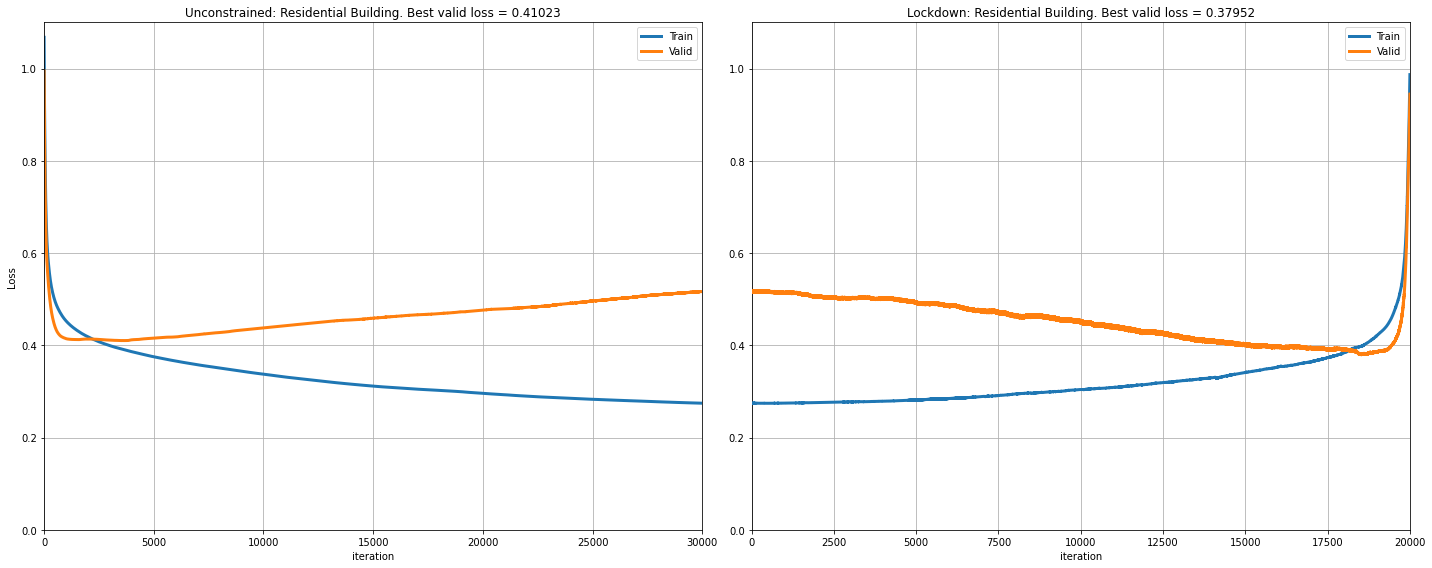

In [37]:
# Plot unconstrained + lockdown loss vs iteration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

train_loss1 = pd.read_csv('data_unconstrained_04CrimeUnnormalized/train_loss01.csv')
valid_loss1 = pd.read_csv('data_unconstrained_04CrimeUnnormalized/valid_loss01.csv')

axes[0].set_ylim(0, 1.1)
axes[0].set_xlim(0, 30000)
axes[0].plot(train_loss1["iteration"].tolist(), train_loss1["loss"].tolist(), label="Train", linewidth=3)
axes[0].plot(valid_loss1["iteration"].tolist(), valid_loss1["loss"].tolist(), label="Valid", linewidth=3)
axes[0].legend()
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("Loss")
axes[0].set_title("Unconstrained: Residential Building. Best valid loss = {:.5f}".format(valid_loss1["loss"].min()))
axes[0].grid(True, zorder=2)

train_loss2 = pd.read_csv('data_lockdown_04CrimeUnnormalized/train_loss01.csv')
valid_loss2 = pd.read_csv('data_lockdown_04CrimeUnnormalized/valid_loss01.csv')

axes[1].set_ylim(0, 1.1)
axes[1].set_xlim(0, 20000)
axes[1].plot(train_loss2["iteration"].tolist(), train_loss2["loss"].tolist(), label="Train", linewidth=3, zorder=5)
axes[1].plot(valid_loss2["iteration"].tolist(), valid_loss2["loss"].tolist(), label="Valid", linewidth=3, zorder=6)
axes[1].legend()
axes[1].set_xlabel("iteration")
axes[1].set_title("Lockdown: Residential Building. Best valid loss = {:.5f}".format(valid_loss2["loss"].min()))
axes[1].grid(True, zorder=2)

plt.tight_layout()
# plt.savefig("data_lockdown_05ResidentialBuilding/loss_vs_iter.pdf", bbox_inches='tight')
plt.show()

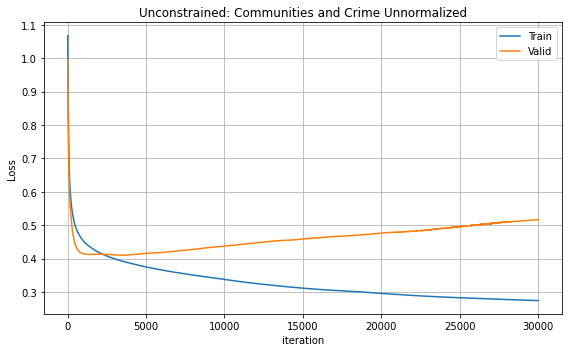

In [592]:
# Plot unconstrained loss function vs iterations
train_loss = pd.read_csv('data_unconstrained_04CrimeUnnormalized/train_loss01.csv')
valid_loss = pd.read_csv('data_unconstrained_04CrimeUnnormalized/valid_loss01.csv')

fig, axes = plt.subplots(figsize=(8,5))

axes.plot(train_loss["iteration"].tolist(), train_loss["loss"].tolist(), label="Train")
axes.plot(valid_loss["iteration"].tolist(), valid_loss["loss"].tolist(), label="Valid")
axes.legend()
axes.set_xlabel("iteration")
axes.set_ylabel("Loss")
axes.set_title("Unconstrained: Communities and Crime Unnormalized")
axes.grid(True, zorder=2)

plt.tight_layout()
# plt.savefig("data_unconstrained_friedman1_04/loss_vs_iter_forward.pdf", bbox_inches='tight')
plt.show()

* ### Comparison

* #### Target 1

In [2]:
# Read distributions
accuracy_lockdown01 = pd.read_csv('data_lockdown_04CrimeUnnormalized/accuracy04_backward01.csv', index_col=0)
accuracy_forward01  = pd.read_csv('data_unconstrained_04CrimeUnnormalized/accuracy04_forward01.csv', index_col=0)
accuracy_xgb01      = pd.read_csv('data_xgb_04CrimeUnnormalized/accuracy04_xgb01.csv')
accuracy_lasso01    = pd.read_csv('data_lasso_04CrimeUnnormalized/accuracy04_lasso01_val.csv', index_col=0)

In [30]:
# R2 & MSE
print("R2 on 'test' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown01['test_r2'].mean(), 
                                            accuracy_lockdown01['test_r2'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward01['test_r2'].mean(), 
                                            accuracy_forward01['test_r2'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb01['test_r2'].mean(), 
                                            accuracy_xgb01['test_r2'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso01['test_r2'].mean(), 
                                            accuracy_lasso01['test_r2'].std()))

print("\nR2 on 'validation' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown01['valid_r2'].mean(), 
                                            accuracy_lockdown01['valid_r2'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward01['valid_r2'].mean(), 
                                            accuracy_forward01['valid_r2'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb01['valid_r2'].mean(), 
                                            accuracy_xgb01['valid_r2'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso01['valid_r2'].mean(), 
                                            accuracy_lasso01['valid_r2'].std()))

R2 on 'test' set:
Lockdown = 0.5545 +/- 0.058
Forward  = 0.5319 +/- 0.060
xgboost  = 0.5248 +/- 0.054
Lasso    = 0.5323 +/- 0.068

R2 on 'validation' set:
Lockdown = 0.5495 +/- 0.062
Forward  = 0.5285 +/- 0.065
xgboost  = 0.5143 +/- 0.061
Lasso    = 0.5186 +/- 0.064


In [31]:
# Print out test results
print("On 'test' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown01['test_r2'], accuracy_forward01['test_r2'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown01['test_r2'], accuracy_xgb01['test_r2'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown01['test_r2'], accuracy_lasso01['test_r2'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

# 
print("\nOn 'validation' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown01['valid_r2'], accuracy_forward01['valid_r2'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown01['valid_r2'], accuracy_xgb01['valid_r2'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown01['valid_r2'], accuracy_lasso01['valid_r2'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

On 'test' set:
Lockdown vs Forward: pvalue=3.417819e-18, statistic=1.069112e+01
Lockdown vs xgboost: pvalue=1.687974e-21, statistic=1.222631e+01
Lockdown vs lasso:   pvalue=1.293794e-11, statistic=7.656906e+00

On 'validation' set:
Lockdown vs Forward: pvalue=5.193508e-15, statistic=9.231409e+00
Lockdown vs xgboost: pvalue=3.098680e-29, statistic=1.601483e+01
Lockdown vs lasso:   pvalue=2.865630e-30, statistic=1.655065e+01


In [23]:
# Relative Root Mean Squared Error
rrmse_lasso = np.sqrt(1.0 - accuracy_lasso01['test_r2'])
print("Lasso   = {:.3f} +/- {:.3f}".format(rrmse_lasso.mean(), rrmse_lasso.std()))

rrmse_GB = np.sqrt(1.0 - accuracy_xgb01['test_r2'])
print("GB      = {:.3f} +/- {:.3f}".format(rrmse_GB.mean(), rrmse_GB.std()))

rrmse_fcnn = np.sqrt(1.0 - accuracy_forward01['test_r2'])
print("FCNN    = {:.3f} +/- {:.3f}".format(rrmse_fcnn.mean(), rrmse_fcnn.std()))

rrmse_lockout = np.sqrt(1.0 - accuracy_lockdown01['test_r2'])
print("Lockout = {:.3f} +/- {:.3f}".format(rrmse_lockout.mean(), rrmse_lockout.std()))

# Print out test results
print("\nOn 'test' set:")
statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_fcnn)
print("Lockdown vs Forward: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_GB)
print("Lockdown vs xgboost: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_lasso)
print("Lockdown vs lasso:   pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

Lasso   = 0.682 +/- 0.049
GB      = 0.688 +/- 0.039
FCNN    = 0.683 +/- 0.043
Lockout = 0.666 +/- 0.043

On 'test' set:
Lockdown vs Forward: pvalue=1.45e-18, statistic=-1.09e+01
Lockdown vs xgboost: pvalue=1.94e-21, statistic=-1.22e+01
Lockdown vs lasso:   pvalue=1.48e-12, statistic=-8.10e+00
